<a href="https://colab.research.google.com/github/Famasmili/WAS/blob/main/Rb_PaLM_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn.functional as F
from einops import rearrange
from torch import einsum, nn

In [16]:
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # TODO: Initialize gamma and beta
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer('beta', torch.zeros(dim))

    def forward(self, x):
        # TODO: Apply layer normalization
         x_norm = F.layer_norm(x, (x.shape[-1],), self.gamma, None, 1e-5)
         return x_norm

In [17]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        # TODO: Initialize fn
        self.fn = fn

    def forward(self, x):
      # TODO: Apply residual connection

      return x + self.fn(x)

In [18]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # TODO: initialize inv_freq
        self.dim = dim
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, max_seq_len, device):
        # TODO: Generate sequence tensor
        seq = torch.arange(max_seq_len, device=device).float().to(device)

        # TODO: Compute frequency product
        freqs = torch.einsum('i , j -> i j', seq, self.inv_freq)

        embeddings = torch.cat([freqs, freqs], dim= -1)

        return embeddings


In [19]:
def rotate_half(x):
    # TODO: Rearrange x into two halves
    xs = x.chunk(2, dim= -1)

    # TODO: Unbind the two halves of x
    x_a = xs[0]
    x_b = xs[1]

    # TODO: Rotate and concatenate the halves
    return torch.cat([-x_b, x_a], dim= -1)

def apply_rotary_pos_emb(pos, t):
    # TODO: Apply rotary position embedding
    rotated_t = rotate_half(t)

    return (t * torch.cos(pos)) + (rotated_t * torch.sin(pos))

In [20]:
class SwiGLU(nn.Module):
    def forward(self, x):
        #TODO: Apply SwiGLU
        x_a, x_b = x.chunk(2, dim= -1)
        swish = x_a * torch.sigmoid(x_a)
        return swish * x_b

In [21]:
class MultiQueryAttention(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8):
        super().__init__()
        # TODO: Initialize heads, dim_heads, scale and attn_inner_dim
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5
        self.attn_inner_dim = dim_head * heads
        self.dim = dim

        # TODO: Initialize projection layers for queries, keys, and values
        self.to_q = nn.Linear(dim, self.attn_inner_dim, bias= False) # Query projection: different for each head
        # Key and Value projections: shared across all heads
        self.to_k = nn.Linear(dim, dim_head, bias= False)
        self.to_v = nn.Linear(dim, dim_head, bias= False)

        # Add output projection to map back to original dimension
        self.to_out = nn.Linear(self.attn_inner_dim, dim, bias=False)

        # self.to_qkv = nn.ModuleList([self.to_q, self.to_k, self.to_v])

        # TODO: Initialize Rotary Embeddings
        self.rotary = RotaryEmbedding(dim_head)

        # TODO: Buffers for caching causal mask and rotary embeddings
        self.register_buffer('cached_rotary', torch.empty(0), persistent=False)
        self.register_buffer('cached_mask', None, persistent=False)

    def get_mask(self, n, device):
        # TODO: Check if the mask is already initialized and has the correct size
        if self.cached_mask is not None and self.cached_mask.shape[-1] >= n:
            return self.cached_mask[:n, :n]

        # TODO: Create a new upper triangular mask of size (n, n)
        mask = torch.ones((n, n), device = device).triu(1).bool()

        # Register the mask as a buffer
        self.register_buffer('cached_mask', mask, persistent= False)

        return mask

    def get_rotary_embedding(self, n, device):
        # TODO: Check if the position embeddings are already initialized and have the correct size

        if self.cached_rotary.shape[0] >= n:
            return self.cached_rotary[:n]

        # TODO: Generate new rotary embeddings for 'n' positions
        pos_emb = self.rotary(n, device)

        # Register the position embeddings as a buffer

        self.register_buffer('cached_rotary', pos_emb, persistent=False)

        return pos_emb

    def forward(self, x):
        """
        x: Tensor of shape (batch, seq_len, dim)
        """
        n, device = x.shape[1], x.device
        h = self.heads


        # TODO: Project inputs to queries, keys, and values
        queries = self.to_q(x)
        keys = self.to_k(x)
        values = self.to_v(x)

        # TODO: Apply rotary positional embeddings
        sin_cos = self.get_rotary_embedding(n, device)


        # Apply rotary positional embeddings to queries and keys
        queries = rearrange(queries, 'b n (h d) -> b h n d', h=h) # (batch, seq_len, dim) -> (batch, seq_len, heads, dim_head)

        queries = apply_rotary_pos_emb(sin_cos, queries)

        keys = apply_rotary_pos_emb(sin_cos, keys)


        # Prepare k,v for attention
        keys = keys.unsqueeze(1)
        values = values.unsqueeze(1)

        # TODO: Scale queries
        queries = queries * self.scale

        # TODO: Compute attention scores
        attn = torch.einsum('b h i d, b h j d -> b h i j', queries, keys.expand(-1, h, -1, -1)) # (batch, heads, seq_len, seq_len)

        # TODO: Apply causal mask
        mask = self.get_mask(n, device)

        attn = attn.masked_fill(mask, float('-inf'))

        # TODO: Softmax normalization
        attn = F.softmax(attn, dim= -1)

        # TODO: Compute attention output
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, values.expand(-1, h, -1, -1)) # (batch, heads, seq_len, dim_head)

        out = rearrange(out, 'b h n d -> b n (h d)') # (batch, heads, seq_len, dim_head) -> (batch, seq_len, dim)

        return self.to_out(out)


In [22]:
class ParallelTransformerBlock(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, ff_mult=4):
        super().__init__()
        # TODO: Initialize the layer norm, MQA
        self.norm = LayerNorm(dim)
        self.mqa = MultiQueryAttention(dim, dim_head, heads)

        # TODO: Initialize the Feedforward layers
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * ff_mult * 2, bias=False),
            SwiGLU(),
            nn.Linear(dim * ff_mult, dim, bias=False)
        )


    def forward(self, x):
        """
        x: Tensor of shape (batch, seq_len, dim)
        """
        # TODO: Apply pre-layer normalization

        x_norm = self.norm(x)

        # TODO: Compute attention output
        x_mqa = self.mqa(x_norm)

        # TODO: Compute feedforward output
        x_ff = self.ff(x_norm)

        return x_ff + x_mqa

## Now, you should have all the code implemented to be able to train the model!
## We provide the training code below.

---



In [23]:
def PaLM(*, dim, num_tokens, depth, dim_head=64, heads=8, ff_mult=4):
    net = nn.Sequential(
        nn.Embedding(num_tokens, dim),
        *[
            Residual(ParallelTransformerBlock(dim=dim, dim_head=dim_head, heads=heads, ff_mult=ff_mult))
            for _ in range(depth)
        ],
        LayerNorm(dim),
        nn.Linear(dim, num_tokens, bias=False)
    )

    # Tie embedding and projection weights
    net[-1].weight = net[0].weight

    # Initialize embedding weights
    nn.init.normal_(net[0].weight, std=0.02)
    return net

In [24]:
palm2 = PaLM(
    num_tokens = 20000,
    dim = 512,
    depth = 12,
    heads = 8,
    dim_head = 64,
)

In [25]:
def exists(val):
    return val is not None


def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out

    return inner

def top_k(logits, thres=0.9):
    k = int((1 - thres) * logits.shape[-1])
    val, ind = torch.topk(logits, k)
    probs = torch.full_like(logits, float("-inf"))
    probs.scatter_(1, ind, val)
    return probs


class AutoregressiveWrapper(nn.Module):
    def __init__(self, net, max_seq_len=2048, pad_value=0):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.pad_value = pad_value
        self.net = net

    @torch.no_grad()
    @eval_decorator
    def generate(
        self,
        start_tokens,
        seq_len,
        eos_token=None,
        temperature=1.0,
        filter_thres=0.9,
        **kwargs
    ):
        b, t, device = *start_tokens.shape, start_tokens.device

        out = start_tokens

        for _ in range(seq_len):
            logits = self.net(out, **kwargs)[:, -1, :]

            filtered_logits = top_k(logits, thres=filter_thres)
            probs = F.softmax(filtered_logits / temperature, dim=-1)

            sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if exists(eos_token):
                is_eos_token = out == eos_token

                if is_eos_token.any(dim=-1).all():
                    # mask out everything after the eos tokens
                    shifted_is_eos_tokens = F.pad(is_eos_token, (1, -1))
                    mask = shifted_is_eos_tokens.float().cumsum(dim=-1) >= 1
                    out = out.masked_fill(mask, self.pad_value)
                    break

        out = out[:, t:]
        return out

    def forward(self, x, **kwargs):
        x_inp, x_labels = x[:, :-1], x[:, 1:]
        logits = self.net(x_inp, **kwargs)
        return F.cross_entropy(rearrange(logits, "b c n -> b n c"), x_labels)

In [26]:
import gzip
import random

import numpy as np
import torch
import torch.optim as optim
import tqdm
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

# constants

NUM_BATCHES = 2500
BATCH_SIZE = 4
GRADIENT_ACCUMULATE_EVERY = 4
LEARNING_RATE = 1e-3
VALIDATE_EVERY = 100
GENERATE_EVERY = 500
GENERATE_LENGTH = 512
SEQ_LEN = 1024

In [27]:
def cycle(loader):
    while True:
        for data in loader:
            yield data


def decode_token(token):
    return str(chr(max(32, token)))


def decode_tokens(tokens):
    return "".join(list(map(decode_token, tokens)))


model = PaLM(num_tokens=256, dim=512, depth=8)

model = AutoregressiveWrapper(model, max_seq_len=SEQ_LEN)
model.cuda()

AutoregressiveWrapper(
  (net): Sequential(
    (0): Embedding(256, 512)
    (1): Residual(
      (fn): ParallelTransformerBlock(
        (norm): LayerNorm()
        (mqa): MultiQueryAttention(
          (to_q): Linear(in_features=512, out_features=512, bias=False)
          (to_k): Linear(in_features=512, out_features=64, bias=False)
          (to_v): Linear(in_features=512, out_features=64, bias=False)
          (to_out): Linear(in_features=512, out_features=512, bias=False)
          (rotary): RotaryEmbedding()
        )
        (ff): Sequential(
          (0): Linear(in_features=512, out_features=4096, bias=False)
          (1): SwiGLU()
          (2): Linear(in_features=2048, out_features=512, bias=False)
        )
      )
    )
    (2): Residual(
      (fn): ParallelTransformerBlock(
        (norm): LayerNorm()
        (mqa): MultiQueryAttention(
          (to_q): Linear(in_features=512, out_features=512, bias=False)
          (to_k): Linear(in_features=512, out_features=64, bias

Change the data path here!




In [28]:
with gzip.open("./enwik8.gz") as file:
    X = np.fromstring(file.read(int(95e6)), dtype=np.uint8)
    trX, vaX = np.split(X, [int(90e6)])
    data_train, data_val = torch.from_numpy(trX), torch.from_numpy(vaX)


class TextSamplerDataset(Dataset):
    def __init__(self, data, seq_len):
        super().__init__()
        self.data = data
        self.seq_len = seq_len

    def __getitem__(self, index):
        rand_start = torch.randint(0, self.data.size(0) - self.seq_len, (1,))
        full_seq = self.data[rand_start : rand_start + self.seq_len + 1].long()
        return full_seq.cuda()

    def __len__(self):
        return self.data.size(0) // self.seq_len


train_dataset = TextSamplerDataset(data_train, SEQ_LEN)
val_dataset = TextSamplerDataset(data_val, SEQ_LEN)
train_loader = cycle(DataLoader(train_dataset, batch_size=BATCH_SIZE))
val_loader = cycle(DataLoader(val_dataset, batch_size=BATCH_SIZE))


optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


<ipython-input-28-0de7207d7243>:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  X = np.fromstring(file.read(int(95e6)), dtype=np.uint8)


In [29]:
training_losses = []
validation_losses = []
generated_tokens = []

for i in tqdm.tqdm(range(NUM_BATCHES), mininterval=10.0, desc="training"):
    model.train()

    for __ in range(GRADIENT_ACCUMULATE_EVERY):
        loss = model(next(train_loader))
        loss.backward()

    print(f"training loss: {loss.item()}")
    training_losses.append(loss.item())
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optim.step()
    optim.zero_grad()

    if i % VALIDATE_EVERY == 0:
        model.eval()
        with torch.no_grad():
            loss = model(next(val_loader))

            print(f"validation loss: {loss.item()}")
            validation_losses.append(loss.item())

    if i % GENERATE_EVERY == 0:
        model.eval()
        inp = random.choice(val_dataset)[:-1]
        prime = decode_tokens(inp)
        print(f"%s \n\n %s", (prime, "*" * 100))

        sample = model.generate(inp[None, ...], GENERATE_LENGTH)
        output_str = decode_tokens(sample[0])
        generated_tokens.append(output_str)
        print(output_str)
        print("*" * 100)
        print()

import joblib
joblib.dump(model, 'Palm_model.pkl')

training:   0%|          | 0/2500 [00:00<?, ?it/s]

training loss: 5.737998008728027
validation loss: 5.3711748123168945
%s 

 %s ('olves the [[National Road]], which got its start in Cumberland , Maryland, and slowly extended westward as the United States expanded (now called [[U.S. Highway 40|U.S. 40]]). It truly was a &quot;national&quot; road, in that it was &quot;macadamized&quot; (&quot;macadam&quot; is called &quot;[[asphalt]]&quot; today), quite an innovation for the nineteenth century. It was far ahead of its time, easily providing the best transportation route of its era. The road had reached [[Columbus, Ohio]], just about the time that Indiana was in its final stage as a territory.   As plans were made to extend the highway to [[Richmond, Indiana]], the call went out for laborers. Knowing that the federal government would pay &quot;top dollar,&quot; workers for a contractor in the [[Indiana Territory]] reportedly named Robert Hoosier asked their boss if they could go work for this higher wage in the neighboring state of [[Ohi

training:   0%|          | 1/2500 [00:30<21:19:30, 30.72s/it]

ÇÇ)Ü¸ # "Þ   Ý°n Ý ÎñÞÝ ¤¤"°#Þ¤#Ü¤"Î¤Ý" ÜÞn)  ) Ý K3ñW#° W¤¤WKÇWKK¤¤Í¤¤Ün K¾ W nÎ"b: ñ) Î Ü¸ ÎÍ"¤ñ¤ ô"  K¦¦¤Î#"n¤   ¸KÞ ¸  W)ôÎ"Ñ  ÝÝW~W ÝÞK¤nK°b¤¾)"##3  ÝÝ¤¾ÑÞ ¸Ý" É) ¸Í3¤ NÎ¸ ÞÝ nÎ¦"¤Ü"n"¦ÝÍÞÝW¤W¤ÜÎãn¸ññÞ¤)¸ K¤  Î  Í Ü  Ý¸jÝ)ônnÝK#°" NÍÝKññÍ)ÜÜñn°¤ Î °)WñÝ ~¤¤ÍnK¤W"W¤n W)W Í¸#WñÜ°ñÝ ¾ )Ý  ÛÍ¸¸ô¸#)¸ÜbÇÎWÎÍ  Î WW# Í)W nÇK" Ñ 3 Ñ¸K¤°¤Î¤nn  ¾¸° n¶ñ ¸Wñ#¤)Ý#Ü#W#ÎK#ÍÎ3   WK¸KnnnÇ# °Ñn)¾ÇK¾W ÇÇñÎÇ¤ Ñ¸#nK)W¤° KK WÞ¤ ¾ Þ¦W¸ ÍW¸Ün ¤¤¦   °Ý ¤ÎÇWn¸¤ñ¾¤°W#   Î ¤¦ñ¤3n ¸° K¸ôÑ¤" "ÝWÝÍ Í n¤
****************************************************************************************************

training loss: 5.335772514343262
training loss: 4.377482891082764
training loss: 4.0419111251831055
training loss: 3.85953950881958
training loss: 3.3149313926696777
training loss: 3.643491506576538


training:   0%|          | 8/2500 [00:41<2:52:16,  4.15s/it] 

training loss: 3.6422159671783447
training loss: 3.4363253116607666
training loss: 3.5587637424468994
training loss: 3.0520596504211426
training loss: 3.437427043914795
training loss: 2.9968693256378174
training loss: 3.1730563640594482


training:   1%|          | 15/2500 [00:51<1:50:52,  2.68s/it]

training loss: 3.146914482116699
training loss: 3.4124295711517334
training loss: 2.835789680480957
training loss: 3.039421796798706
training loss: 3.1706974506378174
training loss: 2.933351516723633
training loss: 3.091813087463379


training:   1%|          | 22/2500 [01:03<1:30:34,  2.19s/it]

training loss: 3.2518937587738037
training loss: 2.9676461219787598
training loss: 2.897796630859375
training loss: 2.7414140701293945
training loss: 3.025810718536377
training loss: 2.864060878753662
training loss: 2.9079947471618652


training:   1%|          | 29/2500 [01:14<1:21:02,  1.97s/it]

training loss: 2.951590061187744
training loss: 2.8417954444885254
training loss: 2.714510202407837
training loss: 2.68562912940979
training loss: 2.6148533821105957
training loss: 2.650346279144287
training loss: 2.8344790935516357


training:   1%|▏         | 36/2500 [01:25<1:15:01,  1.83s/it]

training loss: 2.620518207550049
training loss: 2.966585636138916
training loss: 2.739753246307373
training loss: 2.968674898147583
training loss: 2.7157933712005615
training loss: 2.6653189659118652
training loss: 2.6401422023773193


training:   2%|▏         | 43/2500 [01:36<1:10:55,  1.73s/it]

training loss: 2.808384418487549
training loss: 2.754216194152832
training loss: 2.937741994857788
training loss: 2.6779592037200928
training loss: 2.693732976913452
training loss: 2.875255823135376
training loss: 2.526073455810547


training:   2%|▏         | 50/2500 [01:46<1:08:03,  1.67s/it]

training loss: 2.6996498107910156
training loss: 2.717616081237793
training loss: 2.777811050415039
training loss: 2.521611452102661
training loss: 2.5598089694976807
training loss: 2.655078887939453
training loss: 2.607882499694824


training:   2%|▏         | 57/2500 [01:57<1:06:07,  1.62s/it]

training loss: 2.4381933212280273
training loss: 2.4723644256591797
training loss: 2.483144760131836
training loss: 2.509641170501709
training loss: 2.499208927154541
training loss: 2.4016900062561035
training loss: 2.5143704414367676


training:   3%|▎         | 64/2500 [02:08<1:04:55,  1.60s/it]

training loss: 2.4144656658172607
training loss: 2.4592366218566895
training loss: 2.288435459136963
training loss: 2.4626846313476562
training loss: 2.7668161392211914
training loss: 2.715421199798584
training loss: 2.3423779010772705


training:   3%|▎         | 71/2500 [02:19<1:04:16,  1.59s/it]

training loss: 2.360774040222168
training loss: 2.341625213623047
training loss: 2.4874651432037354
training loss: 2.4885647296905518
training loss: 2.3977503776550293
training loss: 2.376530647277832
training loss: 2.2951765060424805


training:   3%|▎         | 78/2500 [02:30<1:03:53,  1.58s/it]

training loss: 2.5441701412200928
training loss: 2.6665940284729004
training loss: 2.5319814682006836
training loss: 2.6378097534179688
training loss: 2.4993791580200195
training loss: 2.334141254425049
training loss: 2.6463253498077393


training:   3%|▎         | 85/2500 [02:41<1:03:33,  1.58s/it]

training loss: 2.442751407623291
training loss: 2.419666290283203
training loss: 2.1057538986206055
training loss: 2.2975804805755615
training loss: 2.3172943592071533
training loss: 2.1196508407592773
training loss: 2.2530674934387207


training:   4%|▎         | 92/2500 [02:52<1:03:09,  1.57s/it]

training loss: 2.4716763496398926
training loss: 2.3082165718078613
training loss: 2.311671018600464
training loss: 2.4487876892089844
training loss: 2.096808910369873
training loss: 2.1350860595703125
training loss: 2.209994077682495


training:   4%|▍         | 99/2500 [03:03<1:02:43,  1.57s/it]

training loss: 2.1775004863739014
training loss: 2.2277445793151855
training loss: 2.216060161590576
validation loss: 2.271038293838501
training loss: 2.2131152153015137
training loss: 2.215266466140747
training loss: 2.1197152137756348
training loss: 2.2439944744110107


training:   4%|▍         | 106/2500 [03:14<1:02:36,  1.57s/it]

training loss: 2.2413721084594727
training loss: 2.470031499862671
training loss: 2.2378392219543457
training loss: 2.4362800121307373
training loss: 2.148900032043457
training loss: 2.1708312034606934
training loss: 2.2307896614074707


training:   5%|▍         | 113/2500 [03:25<1:02:11,  1.56s/it]

training loss: 2.338345527648926
training loss: 2.2187209129333496
training loss: 2.2511324882507324
training loss: 2.270254135131836
training loss: 2.1651527881622314
training loss: 2.1868131160736084
training loss: 2.2128541469573975


training:   5%|▍         | 120/2500 [03:35<1:01:54,  1.56s/it]

training loss: 2.081380844116211
training loss: 2.181011199951172
training loss: 1.944380760192871
training loss: 2.049386739730835
training loss: 2.2222790718078613
training loss: 2.3019862174987793
training loss: 2.2434492111206055


training:   5%|▌         | 127/2500 [03:46<1:01:42,  1.56s/it]

training loss: 2.2719433307647705
training loss: 1.9322669506072998
training loss: 2.16794490814209
training loss: 2.129840135574341
training loss: 2.310065507888794
training loss: 2.4113900661468506
training loss: 1.9654790163040161


training:   5%|▌         | 134/2500 [03:57<1:01:32,  1.56s/it]

training loss: 2.142756462097168
training loss: 2.1416237354278564
training loss: 2.147010326385498
training loss: 2.210278034210205
training loss: 2.1054320335388184
training loss: 2.1750295162200928
training loss: 2.2271463871002197


training:   6%|▌         | 141/2500 [04:08<1:01:23,  1.56s/it]

training loss: 2.1693413257598877
training loss: 2.0837855339050293
training loss: 2.233198642730713
training loss: 2.1789417266845703
training loss: 1.8998876810073853
training loss: 1.9035027027130127
training loss: 2.0534067153930664


training:   6%|▌         | 148/2500 [04:19<1:01:15,  1.56s/it]

training loss: 2.107027530670166
training loss: 2.047818422317505
training loss: 2.0836875438690186
training loss: 1.9788932800292969
training loss: 2.143338680267334
training loss: 2.08553409576416
training loss: 2.208545446395874


training:   6%|▌         | 155/2500 [04:30<1:01:07,  1.56s/it]

training loss: 2.08670711517334
training loss: 2.251452922821045
training loss: 2.2953574657440186
training loss: 1.9825398921966553
training loss: 2.256613254547119
training loss: 1.7878801822662354
training loss: 2.1757194995880127


training:   6%|▋         | 162/2500 [04:41<1:00:55,  1.56s/it]

training loss: 2.0379788875579834
training loss: 1.9567725658416748
training loss: 2.025637149810791
training loss: 2.1285014152526855
training loss: 2.1325135231018066
training loss: 1.957059621810913
training loss: 1.9781919717788696


training:   7%|▋         | 169/2500 [04:52<1:00:43,  1.56s/it]

training loss: 1.9573302268981934
training loss: 1.962785005569458
training loss: 1.9222064018249512
training loss: 1.960014820098877
training loss: 1.910615086555481
training loss: 2.016749620437622
training loss: 2.230210304260254


training:   7%|▋         | 176/2500 [05:03<1:00:32,  1.56s/it]

training loss: 1.978108286857605
training loss: 2.176781415939331
training loss: 1.7916724681854248
training loss: 2.1433520317077637
training loss: 2.0451908111572266
training loss: 2.0293877124786377
training loss: 1.9404752254486084


training:   7%|▋         | 183/2500 [05:14<1:00:23,  1.56s/it]

training loss: 2.0869288444519043
training loss: 2.101649284362793
training loss: 2.025634527206421
training loss: 1.981629729270935
training loss: 1.9074428081512451
training loss: 1.8702012300491333
training loss: 1.9165325164794922


training:   8%|▊         | 190/2500 [05:25<1:00:10,  1.56s/it]

training loss: 2.2260825634002686
training loss: 2.2147350311279297
training loss: 2.103729248046875
training loss: 2.1313934326171875
training loss: 2.0688445568084717
training loss: 1.8663195371627808
training loss: 2.035269021987915


training:   8%|▊         | 197/2500 [05:36<59:58,  1.56s/it]  

training loss: 1.9479560852050781
training loss: 2.126187801361084
training loss: 1.8244363069534302
training loss: 2.2414205074310303
training loss: 1.8685495853424072
validation loss: 2.0227692127227783
training loss: 2.239335775375366
training loss: 1.9744162559509277


training:   8%|▊         | 204/2500 [05:47<1:00:00,  1.57s/it]

training loss: 1.9805028438568115
training loss: 1.6027753353118896
training loss: 2.02325439453125
training loss: 1.9196693897247314
training loss: 1.8948431015014648
training loss: 1.9830939769744873
training loss: 1.439835548400879


training:   8%|▊         | 211/2500 [05:58<59:44,  1.57s/it]  

training loss: 2.0390753746032715
training loss: 1.978878378868103
training loss: 2.031627893447876
training loss: 1.8412673473358154
training loss: 1.7646687030792236
training loss: 1.8858928680419922
training loss: 1.9040956497192383


training:   9%|▊         | 218/2500 [06:09<59:30,  1.56s/it]

training loss: 2.041161060333252
training loss: 1.8518189191818237
training loss: 1.7128828763961792
training loss: 1.9697591066360474
training loss: 1.9369601011276245
training loss: 2.047853469848633
training loss: 1.9780802726745605


training:   9%|▉         | 225/2500 [06:20<59:17,  1.56s/it]

training loss: 1.9826579093933105
training loss: 1.8332839012145996
training loss: 1.8617645502090454
training loss: 1.8380823135375977
training loss: 1.937375783920288
training loss: 1.8508011102676392
training loss: 1.6572864055633545


training:   9%|▉         | 232/2500 [06:31<59:03,  1.56s/it]

training loss: 1.853684425354004
training loss: 1.9173771142959595
training loss: 1.836036205291748
training loss: 2.094937324523926
training loss: 2.03057599067688
training loss: 1.6134202480316162
training loss: 1.8142859935760498


training:  10%|▉         | 239/2500 [06:42<58:52,  1.56s/it]

training loss: 1.8891913890838623
training loss: 1.8851172924041748
training loss: 1.7870506048202515
training loss: 1.7915505170822144
training loss: 1.9825890064239502
training loss: 2.0134971141815186
training loss: 1.8933675289154053


training:  10%|▉         | 246/2500 [06:52<58:39,  1.56s/it]

training loss: 1.6934576034545898
training loss: 1.4334990978240967
training loss: 1.9328672885894775
training loss: 1.7279632091522217
training loss: 1.5898115634918213
training loss: 1.9164321422576904
training loss: 1.9149243831634521


training:  10%|█         | 253/2500 [07:03<58:27,  1.56s/it]

training loss: 1.9617815017700195
training loss: 1.7304589748382568
training loss: 1.847731351852417
training loss: 1.811661958694458
training loss: 1.506443977355957
training loss: 1.6574394702911377
training loss: 1.884782075881958


training:  10%|█         | 260/2500 [07:14<58:17,  1.56s/it]

training loss: 1.645423412322998
training loss: 1.6498390436172485
training loss: 1.9775333404541016
training loss: 1.8575544357299805
training loss: 1.9060750007629395
training loss: 1.8732835054397583
training loss: 1.6172994375228882


training:  11%|█         | 267/2500 [07:25<58:07,  1.56s/it]

training loss: 1.6866624355316162
training loss: 1.374711036682129
training loss: 1.883392333984375
training loss: 1.7611082792282104
training loss: 1.6325860023498535
training loss: 1.8206171989440918
training loss: 1.7341797351837158


training:  11%|█         | 274/2500 [07:36<57:55,  1.56s/it]

training loss: 1.8866190910339355
training loss: 1.7129409313201904
training loss: 1.634352445602417
training loss: 1.8259930610656738
training loss: 1.842140555381775
training loss: 1.8839144706726074
training loss: 2.0601887702941895


training:  11%|█         | 281/2500 [07:47<57:45,  1.56s/it]

training loss: 1.6704566478729248
training loss: 1.5496336221694946
training loss: 1.8422162532806396
training loss: 1.9952292442321777
training loss: 1.7120870351791382
training loss: 1.6440898180007935
training loss: 1.7255194187164307


training:  12%|█▏        | 288/2500 [07:58<57:34,  1.56s/it]

training loss: 1.7813642024993896
training loss: 2.027442455291748
training loss: 1.7389616966247559
training loss: 1.8034496307373047
training loss: 1.6323232650756836
training loss: 1.694786548614502
training loss: 1.7807371616363525


training:  12%|█▏        | 295/2500 [08:09<57:22,  1.56s/it]

training loss: 2.14900541305542
training loss: 1.5832383632659912
training loss: 1.771568775177002
training loss: 1.5712182521820068
training loss: 1.4925425052642822
training loss: 1.889468789100647
training loss: 1.6594252586364746
validation loss: 1.818049669265747


training:  12%|█▏        | 302/2500 [08:20<57:24,  1.57s/it]

training loss: 1.7972103357315063
training loss: 1.7324942350387573
training loss: 1.6708452701568604
training loss: 1.7771236896514893
training loss: 1.6369757652282715
training loss: 1.852778673171997
training loss: 1.657994031906128


training:  12%|█▏        | 309/2500 [08:31<57:08,  1.56s/it]

training loss: 1.7267404794692993
training loss: 1.7676761150360107
training loss: 1.5808320045471191
training loss: 1.8368825912475586
training loss: 1.6902775764465332
training loss: 1.453317403793335
training loss: 1.8591209650039673


training:  13%|█▎        | 316/2500 [08:42<56:54,  1.56s/it]

training loss: 1.5982972383499146
training loss: 1.706066370010376
training loss: 1.707268238067627
training loss: 1.7391196489334106
training loss: 1.6228046417236328
training loss: 1.609552264213562
training loss: 1.5269516706466675


training:  13%|█▎        | 323/2500 [08:53<56:39,  1.56s/it]

training loss: 1.6383978128433228
training loss: 1.8319189548492432
training loss: 1.6697183847427368
training loss: 1.9727445840835571
training loss: 1.6817212104797363
training loss: 1.687697172164917
training loss: 2.18245530128479


training:  13%|█▎        | 330/2500 [09:04<56:27,  1.56s/it]

training loss: 1.6992133855819702
training loss: 1.2625901699066162
training loss: 1.67191743850708
training loss: 1.7116947174072266
training loss: 1.8902039527893066
training loss: 1.7842283248901367
training loss: 1.7534997463226318


training:  13%|█▎        | 337/2500 [09:15<56:17,  1.56s/it]

training loss: 1.6603275537490845
training loss: 1.7618341445922852
training loss: 1.7347321510314941
training loss: 1.7045257091522217
training loss: 1.7277493476867676
training loss: 1.820265293121338
training loss: 1.7050286531448364


training:  14%|█▍        | 344/2500 [09:26<56:06,  1.56s/it]

training loss: 1.5946555137634277
training loss: 1.7117114067077637
training loss: 1.7614171504974365
training loss: 1.7262225151062012
training loss: 1.719377040863037
training loss: 1.804610013961792
training loss: 1.7029411792755127


training:  14%|█▍        | 351/2500 [09:36<55:52,  1.56s/it]

training loss: 1.6516203880310059
training loss: 1.649463176727295
training loss: 1.8254473209381104
training loss: 1.790184497833252
training loss: 1.7031793594360352
training loss: 1.658547282218933
training loss: 1.855450987815857


training:  14%|█▍        | 358/2500 [09:47<55:40,  1.56s/it]

training loss: 1.6099879741668701
training loss: 1.8793916702270508
training loss: 1.6921169757843018
training loss: 1.5530787706375122
training loss: 1.5703444480895996
training loss: 1.645935297012329
training loss: 1.7566208839416504


training:  15%|█▍        | 365/2500 [09:58<55:29,  1.56s/it]

training loss: 1.8865375518798828
training loss: 1.810789942741394
training loss: 1.2781612873077393
training loss: 1.5806355476379395
training loss: 1.5913546085357666
training loss: 1.6647926568984985
training loss: 1.7772185802459717


training:  15%|█▍        | 372/2500 [10:09<55:19,  1.56s/it]

training loss: 1.7457630634307861
training loss: 1.5608441829681396
training loss: 1.4791103601455688
training loss: 1.2487554550170898
training loss: 1.6836704015731812
training loss: 1.8551400899887085
training loss: 1.5866062641143799


training:  15%|█▌        | 379/2500 [10:20<55:08,  1.56s/it]

training loss: 1.688817024230957
training loss: 1.3000481128692627
training loss: 1.7533280849456787
training loss: 1.764593243598938
training loss: 1.3668370246887207
training loss: 1.8214632272720337
training loss: 1.8025997877120972


training:  15%|█▌        | 386/2500 [10:31<54:57,  1.56s/it]

training loss: 1.6179754734039307
training loss: 1.5882490873336792
training loss: 1.5942177772521973
training loss: 1.602708339691162
training loss: 1.7348994016647339
training loss: 1.7073674201965332
training loss: 1.6581602096557617


training:  16%|█▌        | 393/2500 [10:42<54:47,  1.56s/it]

training loss: 1.5673049688339233
training loss: 1.7666044235229492
training loss: 1.739196538925171
training loss: 1.6676020622253418
training loss: 1.7005550861358643
training loss: 1.5489192008972168
training loss: 1.8110342025756836


training:  16%|█▌        | 400/2500 [10:53<54:35,  1.56s/it]

training loss: 1.6381855010986328
training loss: 1.6807125806808472
validation loss: 1.7488527297973633
training loss: 1.4825520515441895
training loss: 1.4519805908203125
training loss: 1.7702171802520752
training loss: 1.564544916152954
training loss: 1.664841890335083


training:  16%|█▋        | 407/2500 [11:04<54:36,  1.57s/it]

training loss: 1.5841710567474365
training loss: 1.6717106103897095
training loss: 1.6130008697509766
training loss: 1.6962182521820068
training loss: 1.6184334754943848
training loss: 1.6231002807617188
training loss: 1.5628081560134888


training:  17%|█▋        | 414/2500 [11:15<54:20,  1.56s/it]

training loss: 1.6553288698196411
training loss: 1.8488473892211914
training loss: 1.3844361305236816
training loss: 1.747289776802063
training loss: 1.525357723236084
training loss: 1.646180272102356
training loss: 1.6155091524124146


training:  17%|█▋        | 421/2500 [11:26<54:08,  1.56s/it]

training loss: 1.6130393743515015
training loss: 1.8692681789398193
training loss: 1.718033790588379
training loss: 1.6204257011413574
training loss: 1.6567120552062988
training loss: 1.7056620121002197
training loss: 1.5818101167678833


training:  17%|█▋        | 428/2500 [11:37<53:54,  1.56s/it]

training loss: 1.412345290184021
training loss: 1.4981601238250732
training loss: 1.6747437715530396
training loss: 1.7907081842422485
training loss: 1.570430040359497
training loss: 1.665224313735962
training loss: 1.9193094968795776


training:  17%|█▋        | 435/2500 [11:48<53:41,  1.56s/it]

training loss: 1.6383692026138306
training loss: 1.7672359943389893
training loss: 1.6588423252105713
training loss: 1.8896732330322266
training loss: 1.6302368640899658
training loss: 1.6938828229904175
training loss: 1.6616097688674927


training:  18%|█▊        | 442/2500 [11:58<53:28,  1.56s/it]

training loss: 1.709011197090149
training loss: 1.479656457901001
training loss: 1.4682193994522095
training loss: 1.4029862880706787
training loss: 1.6093109846115112
training loss: 1.4692058563232422
training loss: 1.7582862377166748


training:  18%|█▊        | 449/2500 [12:09<53:18,  1.56s/it]

training loss: 1.589604377746582
training loss: 1.7065188884735107
training loss: 1.6298878192901611
training loss: 1.4098787307739258
training loss: 1.3534445762634277
training loss: 1.8228814601898193
training loss: 1.3423936367034912


training:  18%|█▊        | 456/2500 [12:20<53:07,  1.56s/it]

training loss: 1.243638038635254
training loss: 1.6250882148742676
training loss: 1.7309679985046387
training loss: 1.6988539695739746
training loss: 1.661848783493042
training loss: 1.396575689315796
training loss: 1.755828857421875


training:  19%|█▊        | 463/2500 [12:31<52:56,  1.56s/it]

training loss: 1.6775360107421875
training loss: 1.5777164697647095
training loss: 1.6782461404800415
training loss: 1.6062105894088745
training loss: 1.5440165996551514
training loss: 1.6691639423370361
training loss: 1.57378351688385


training:  19%|█▉        | 470/2500 [12:42<52:45,  1.56s/it]

training loss: 1.4953584671020508
training loss: 1.7024829387664795
training loss: 1.6234709024429321
training loss: 1.6406972408294678
training loss: 1.4990437030792236
training loss: 1.575031042098999
training loss: 1.7334012985229492


training:  19%|█▉        | 477/2500 [12:53<52:33,  1.56s/it]

training loss: 1.5230406522750854
training loss: 1.717644453048706
training loss: 1.4863581657409668
training loss: 1.6424671411514282
training loss: 1.4794880151748657
training loss: 1.630070686340332
training loss: 1.2845865488052368


training:  19%|█▉        | 484/2500 [13:04<52:23,  1.56s/it]

training loss: 1.440575122833252
training loss: 1.709250807762146
training loss: 1.7481319904327393
training loss: 1.92448091506958
training loss: 1.4220452308654785
training loss: 1.633610725402832
training loss: 1.5513771772384644


training:  20%|█▉        | 491/2500 [13:15<52:12,  1.56s/it]

training loss: 1.5033600330352783
training loss: 1.6316051483154297
training loss: 1.4041740894317627
training loss: 1.4338945150375366
training loss: 1.6816660165786743
training loss: 1.6073648929595947
training loss: 1.516735315322876


training:  20%|█▉        | 498/2500 [13:26<52:00,  1.56s/it]

training loss: 1.4787112474441528
training loss: 1.6253074407577515
training loss: 1.4885114431381226
training loss: 1.676842212677002
validation loss: 1.6554687023162842
%s 

 %s ("\\right )}^3\\frac{(n-l-1)!}{2n[(n+l)!]} } e^{- \\rho / 2} \\rho^{l} L_{n-l-1}^{2l+1}(\\rho) \\cdot Y_{l,m}(\\theta, \\phi ) &lt;/math&gt; where: * &lt;math&gt; \\rho = {2r \\over {a_0}} &lt;/math&gt; and ''a''&lt;sub&gt;0&lt;/sub&gt; is the [[Bohr radius]]. * &lt;math&gt; L_{n-l-1}^{2l+1}(\\rho) &lt;/math&gt; are the [[Generalized Laguerre polynomials]] of degree ''n''&lt;sub&gt;r&lt;/sub&gt;. * &lt;math&gt; Y_{l,m}(\\theta, \\phi ) &lt;/math&gt; is a [[spherical harmonic]].  The [[eigenvalue]]s are: * For [[Angular momentum operator]]: :: &lt;math&gt; L^2 | n, l, m \\rang = {\\hbar}^2 l(l+1) | n, l, m \\rang &lt;/math&gt; :: &lt;math&gt; L_z | n, l, m \\rang = \\hbar m | n, l, m \\rang &lt;/math&gt; * For the [[Hamiltonian (quantum mechanics)|Hamiltonian]]: :: &lt;math&gt; H| n, l, m \\rang = E_n | n, l, 

training:  20%|██        | 501/2500 [13:59<1:40:22,  3.01s/it]

cton in the subsen doctun trace air has course in thrue diveions (A. '''gaia of emocracily additible of beteral actives bosen reactors in 15 results '''' at the admebisted also bechnomy-meet petained by a hasewhight cell. Consing the processive &ot;Machin such are astandance world differented '''Aeuses''' wichany &lt;/tr&g ampediation of supporting these use red to rest a bass is then statings '''all expensivese and bambot;''' subder sext reb has [[heado musivia|rign|apopos]] (for the millistimizabishave | 
****************************************************************************************************

training loss: 1.3318805694580078
training loss: 1.5728583335876465
training loss: 1.5491764545440674
training loss: 1.5474672317504883
training loss: 1.5726882219314575
training loss: 1.6497983932495117


training:  20%|██        | 508/2500 [14:09<1:23:32,  2.52s/it]

training loss: 1.5445902347564697
training loss: 1.6050209999084473
training loss: 1.625779151916504
training loss: 1.762765645980835
training loss: 1.471991777420044
training loss: 1.5710835456848145
training loss: 1.6117849349975586


training:  21%|██        | 515/2500 [14:20<1:12:53,  2.20s/it]

training loss: 1.5156469345092773
training loss: 1.5716056823730469
training loss: 1.5452244281768799
training loss: 1.6044174432754517
training loss: 1.609692931175232
training loss: 1.5052766799926758
training loss: 1.5355373620986938


training:  21%|██        | 522/2500 [14:31<1:05:51,  2.00s/it]

training loss: 1.6991212368011475
training loss: 1.5910199880599976
training loss: 1.7598916292190552
training loss: 1.8025708198547363
training loss: 1.7015652656555176
training loss: 1.5370726585388184
training loss: 1.4996771812438965


training:  21%|██        | 529/2500 [14:42<1:01:07,  1.86s/it]

training loss: 1.50942063331604
training loss: 1.296194076538086
training loss: 1.5181905031204224
training loss: 1.4116568565368652
training loss: 1.823821783065796
training loss: 1.7723350524902344
training loss: 1.4938325881958008


training:  21%|██▏       | 536/2500 [14:53<57:51,  1.77s/it]  

training loss: 1.413500428199768
training loss: 1.5319130420684814
training loss: 1.4132593870162964
training loss: 1.4689269065856934
training loss: 1.664975643157959
training loss: 1.4039568901062012
training loss: 1.4368016719818115


training:  22%|██▏       | 543/2500 [15:04<55:35,  1.70s/it]

training loss: 1.3952956199645996
training loss: 1.5774002075195312
training loss: 1.424649953842163
training loss: 1.3784782886505127
training loss: 1.5580947399139404
training loss: 1.5874371528625488
training loss: 1.4823472499847412


training:  22%|██▏       | 550/2500 [15:15<53:57,  1.66s/it]

training loss: 1.5803959369659424
training loss: 2.0353333950042725
training loss: 1.6067116260528564
training loss: 1.5156762599945068
training loss: 1.4680864810943604
training loss: 1.4203393459320068
training loss: 1.1836624145507812


training:  22%|██▏       | 557/2500 [15:26<52:46,  1.63s/it]

training loss: 1.6558043956756592
training loss: 1.3992716073989868
training loss: 1.52864408493042
training loss: 1.7977626323699951
training loss: 1.7797482013702393
training loss: 1.4353605508804321
training loss: 1.5686578750610352


training:  23%|██▎       | 564/2500 [15:37<51:52,  1.61s/it]

training loss: 1.5250403881072998
training loss: 1.8125102519989014
training loss: 1.3970258235931396
training loss: 1.6749553680419922
training loss: 1.5384601354599
training loss: 1.4418399333953857
training loss: 1.5123865604400635


training:  23%|██▎       | 571/2500 [15:48<51:13,  1.59s/it]

training loss: 1.6508235931396484
training loss: 1.5328640937805176
training loss: 1.5406601428985596
training loss: 1.5149641036987305
training loss: 1.532137155532837
training loss: 1.490835428237915
training loss: 1.421269178390503


training:  23%|██▎       | 578/2500 [15:59<50:42,  1.58s/it]

training loss: 1.4660210609436035
training loss: 1.587902307510376
training loss: 1.3581887483596802
training loss: 1.543139934539795
training loss: 1.4119760990142822
training loss: 1.3434488773345947
training loss: 1.854214072227478


training:  23%|██▎       | 585/2500 [16:10<50:18,  1.58s/it]

training loss: 1.7039827108383179
training loss: 1.6432232856750488
training loss: 1.4701343774795532
training loss: 1.5871604681015015
training loss: 1.5426139831542969
training loss: 1.4833202362060547
training loss: 1.4422298669815063


training:  24%|██▎       | 592/2500 [16:20<49:57,  1.57s/it]

training loss: 1.3828362226486206
training loss: 1.6357624530792236
training loss: 1.3784890174865723
training loss: 1.4015487432479858
training loss: 1.5312864780426025
training loss: 1.4516568183898926
training loss: 1.4700822830200195


training:  24%|██▍       | 599/2500 [16:31<49:39,  1.57s/it]

training loss: 1.5613892078399658
training loss: 1.57694673538208
training loss: 1.461153507232666
validation loss: 1.5541309118270874
training loss: 1.5443394184112549
training loss: 1.563858151435852
training loss: 1.5323678255081177
training loss: 1.3786609172821045


training:  24%|██▍       | 606/2500 [16:42<49:34,  1.57s/it]

training loss: 1.570383071899414
training loss: 1.4971647262573242
training loss: 1.3806833028793335
training loss: 1.6618616580963135
training loss: 1.3759281635284424
training loss: 1.4242935180664062
training loss: 1.2357245683670044


training:  25%|██▍       | 613/2500 [16:53<49:17,  1.57s/it]

training loss: 1.5324212312698364
training loss: 1.5912737846374512
training loss: 1.471358060836792
training loss: 1.6919498443603516
training loss: 1.274625539779663
training loss: 1.3672064542770386
training loss: 1.5210983753204346


training:  25%|██▍       | 620/2500 [17:04<49:01,  1.56s/it]

training loss: 1.5462701320648193
training loss: 1.4878737926483154
training loss: 1.3670554161071777
training loss: 1.45999276638031
training loss: 1.499708652496338
training loss: 1.3999178409576416
training loss: 1.3550446033477783


training:  25%|██▌       | 627/2500 [17:15<48:47,  1.56s/it]

training loss: 1.3930481672286987
training loss: 1.4400800466537476
training loss: 1.3177361488342285
training loss: 1.6008586883544922
training loss: 1.5239801406860352
training loss: 1.522165298461914
training loss: 1.2948755025863647


training:  25%|██▌       | 634/2500 [17:26<48:33,  1.56s/it]

training loss: 1.3563755750656128
training loss: 1.525261640548706
training loss: 1.4388614892959595
training loss: 1.3179677724838257
training loss: 1.43059504032135
training loss: 1.340510606765747
training loss: 1.573471188545227


training:  26%|██▌       | 641/2500 [17:37<48:21,  1.56s/it]

training loss: 1.3596302270889282
training loss: 1.3231686353683472
training loss: 1.4780319929122925
training loss: 1.759747862815857
training loss: 1.4784038066864014
training loss: 1.3278144598007202
training loss: 1.6997076272964478


training:  26%|██▌       | 648/2500 [17:48<48:08,  1.56s/it]

training loss: 1.6866987943649292
training loss: 1.1608946323394775
training loss: 1.4185981750488281
training loss: 1.4164520502090454
training loss: 1.5497105121612549
training loss: 1.329622507095337
training loss: 1.6335231065750122


training:  26%|██▌       | 655/2500 [17:59<47:58,  1.56s/it]

training loss: 1.467562198638916
training loss: 1.5497236251831055
training loss: 1.4570331573486328
training loss: 1.4780960083007812
training loss: 1.552839994430542
training loss: 1.5627204179763794
training loss: 1.358239769935608


training:  26%|██▋       | 662/2500 [18:10<47:47,  1.56s/it]

training loss: 1.2315571308135986
training loss: 1.5722732543945312
training loss: 1.4180442094802856
training loss: 1.5328365564346313
training loss: 1.4570646286010742
training loss: 1.4927468299865723
training loss: 1.5615953207015991


training:  27%|██▋       | 669/2500 [18:21<47:35,  1.56s/it]

training loss: 1.4892809391021729
training loss: 1.4078316688537598
training loss: 1.4972296953201294
training loss: 1.5320993661880493
training loss: 1.5560405254364014
training loss: 1.5173940658569336
training loss: 1.4923896789550781


training:  27%|██▋       | 676/2500 [18:32<47:23,  1.56s/it]

training loss: 1.3521332740783691
training loss: 1.3656702041625977
training loss: 1.5200791358947754
training loss: 1.502824068069458
training loss: 1.5098342895507812
training loss: 1.6729120016098022
training loss: 1.5705276727676392


training:  27%|██▋       | 683/2500 [18:42<47:12,  1.56s/it]

training loss: 1.3809674978256226
training loss: 1.421772837638855
training loss: 1.480610966682434
training loss: 1.3146922588348389
training loss: 1.417450189590454
training loss: 1.4873418807983398
training loss: 1.398827075958252


training:  28%|██▊       | 690/2500 [18:53<47:02,  1.56s/it]

training loss: 1.3948391675949097
training loss: 1.5520801544189453
training loss: 1.3566925525665283
training loss: 1.3971391916275024
training loss: 1.746221661567688
training loss: 1.4714162349700928
training loss: 1.6397196054458618


training:  28%|██▊       | 697/2500 [19:04<46:50,  1.56s/it]

training loss: 1.340723991394043
training loss: 1.7192003726959229
training loss: 1.298935890197754
training loss: 1.377866506576538
training loss: 1.3147205114364624
validation loss: 1.6840592622756958
training loss: 1.3763889074325562
training loss: 1.3561131954193115


training:  28%|██▊       | 704/2500 [19:15<46:51,  1.57s/it]

training loss: 1.5155692100524902
training loss: 1.2426193952560425
training loss: 1.490491271018982
training loss: 1.6658161878585815
training loss: 1.4396824836730957
training loss: 1.4267592430114746
training loss: 1.498617172241211


training:  28%|██▊       | 711/2500 [19:26<46:37,  1.56s/it]

training loss: 1.7261524200439453
training loss: 1.5242908000946045
training loss: 1.4727933406829834
training loss: 1.3111789226531982
training loss: 1.5580307245254517
training loss: 1.7639405727386475
training loss: 1.3724017143249512


training:  29%|██▊       | 718/2500 [19:37<46:22,  1.56s/it]

training loss: 1.5702804327011108
training loss: 1.5357900857925415
training loss: 1.3464829921722412
training loss: 1.580291509628296
training loss: 1.4795551300048828
training loss: 1.526656985282898
training loss: 1.5182671546936035


training:  29%|██▉       | 725/2500 [19:48<46:09,  1.56s/it]

training loss: 1.449558138847351
training loss: 1.3535816669464111
training loss: 1.3754127025604248
training loss: 1.374267339706421
training loss: 1.5943852663040161
training loss: 1.5591267347335815
training loss: 1.3358290195465088


training:  29%|██▉       | 732/2500 [19:59<45:57,  1.56s/it]

training loss: 1.52338445186615
training loss: 1.4779541492462158
training loss: 1.2793724536895752
training loss: 1.424342155456543
training loss: 1.5270357131958008
training loss: 1.5128726959228516
training loss: 1.3550386428833008


training:  30%|██▉       | 739/2500 [20:10<45:45,  1.56s/it]

training loss: 1.3975332975387573
training loss: 1.3951647281646729
training loss: 1.4443299770355225
training loss: 1.5941054821014404
training loss: 1.3160134553909302
training loss: 1.39714515209198
training loss: 1.5010533332824707


training:  30%|██▉       | 746/2500 [20:21<45:34,  1.56s/it]

training loss: 1.3469330072402954
training loss: 1.2786284685134888
training loss: 1.4139118194580078
training loss: 1.436195969581604
training loss: 1.4329168796539307
training loss: 1.6480047702789307
training loss: 1.6251819133758545


training:  30%|███       | 753/2500 [20:32<45:22,  1.56s/it]

training loss: 1.3938751220703125
training loss: 1.517709493637085
training loss: 1.2011021375656128
training loss: 1.5211851596832275
training loss: 1.445246696472168
training loss: 1.5313490629196167
training loss: 1.4834270477294922


training:  30%|███       | 760/2500 [20:43<45:10,  1.56s/it]

training loss: 1.4945361614227295
training loss: 1.4638991355895996
training loss: 1.3420193195343018
training loss: 1.5326380729675293
training loss: 1.425214409828186
training loss: 1.371286153793335
training loss: 1.4411758184432983


training:  31%|███       | 767/2500 [20:53<44:58,  1.56s/it]

training loss: 1.5232220888137817
training loss: 1.5432605743408203
training loss: 1.5190256834030151
training loss: 1.3712341785430908
training loss: 1.563564419746399
training loss: 1.4389879703521729
training loss: 1.6014087200164795


training:  31%|███       | 774/2500 [21:04<44:47,  1.56s/it]

training loss: 1.4000355005264282
training loss: 1.4373323917388916
training loss: 1.5316853523254395
training loss: 1.1996949911117554
training loss: 1.6183836460113525
training loss: 1.40557861328125
training loss: 1.2381166219711304


training:  31%|███       | 781/2500 [21:15<44:36,  1.56s/it]

training loss: 1.6098659038543701
training loss: 1.4155446290969849
training loss: 1.1908625364303589
training loss: 1.4754619598388672
training loss: 1.495154619216919
training loss: 1.396734356880188
training loss: 1.3996155261993408


training:  32%|███▏      | 788/2500 [21:26<44:26,  1.56s/it]

training loss: 1.4036058187484741
training loss: 1.5057861804962158
training loss: 1.5113732814788818
training loss: 1.2640323638916016
training loss: 1.572704553604126
training loss: 1.3149136304855347
training loss: 1.5176408290863037


training:  32%|███▏      | 795/2500 [21:37<44:16,  1.56s/it]

training loss: 1.0553648471832275
training loss: 1.630018711090088
training loss: 1.5075445175170898
training loss: 1.4408758878707886
training loss: 1.4232428073883057
training loss: 1.3274294137954712
training loss: 1.5709649324417114
validation loss: 1.5442044734954834


training:  32%|███▏      | 802/2500 [21:48<44:14,  1.56s/it]

training loss: 1.36782705783844
training loss: 1.4244568347930908
training loss: 1.4683740139007568
training loss: 1.7141834497451782
training loss: 1.5007953643798828
training loss: 1.2868995666503906
training loss: 1.2058420181274414


training:  32%|███▏      | 809/2500 [21:59<44:00,  1.56s/it]

training loss: 1.4089549779891968
training loss: 1.3447699546813965
training loss: 1.3983291387557983
training loss: 1.5346930027008057
training loss: 1.173547625541687
training loss: 1.617387056350708
training loss: 1.1190288066864014


training:  33%|███▎      | 816/2500 [22:10<43:48,  1.56s/it]

training loss: 1.2577800750732422
training loss: 1.5956623554229736
training loss: 1.5100278854370117
training loss: 1.3293148279190063
training loss: 1.4746845960617065
training loss: 1.4833488464355469
training loss: 1.5796334743499756


training:  33%|███▎      | 823/2500 [22:21<43:35,  1.56s/it]

training loss: 1.5608057975769043
training loss: 1.3871608972549438
training loss: 1.4056930541992188
training loss: 1.5382554531097412
training loss: 1.5181856155395508
training loss: 1.3922512531280518
training loss: 1.682823657989502


training:  33%|███▎      | 830/2500 [22:32<43:24,  1.56s/it]

training loss: 1.4260081052780151
training loss: 1.2992291450500488
training loss: 1.5284264087677002
training loss: 1.5168167352676392
training loss: 1.452870488166809
training loss: 1.3198444843292236
training loss: 1.395399808883667


training:  33%|███▎      | 837/2500 [22:43<43:13,  1.56s/it]

training loss: 1.3110148906707764
training loss: 1.2713935375213623
training loss: 1.4657764434814453
training loss: 1.3920478820800781
training loss: 1.404924750328064
training loss: 1.397673487663269
training loss: 1.4351000785827637


training:  34%|███▍      | 844/2500 [22:54<43:01,  1.56s/it]

training loss: 1.528257131576538
training loss: 1.4703569412231445
training loss: 1.4402620792388916
training loss: 1.3533577919006348
training loss: 1.440286636352539
training loss: 1.421606421470642
training loss: 1.4588932991027832


training:  34%|███▍      | 851/2500 [23:04<42:50,  1.56s/it]

training loss: 1.400874137878418
training loss: 1.4655418395996094
training loss: 1.4982200860977173
training loss: 1.4459320306777954
training loss: 1.38371741771698
training loss: 1.5115442276000977
training loss: 1.3345391750335693


training:  34%|███▍      | 858/2500 [23:15<42:38,  1.56s/it]

training loss: 1.5939230918884277
training loss: 1.4545040130615234
training loss: 1.2677693367004395
training loss: 1.3761749267578125
training loss: 1.4725489616394043
training loss: 1.4850412607192993
training loss: 1.5432639122009277


training:  35%|███▍      | 865/2500 [23:26<42:27,  1.56s/it]

training loss: 1.5045607089996338
training loss: 1.36126708984375
training loss: 1.4336607456207275
training loss: 1.3755958080291748
training loss: 1.4666705131530762
training loss: 1.529695987701416
training loss: 1.2977339029312134


training:  35%|███▍      | 872/2500 [23:37<42:18,  1.56s/it]

training loss: 1.3205856084823608
training loss: 1.4170886278152466
training loss: 1.4532891511917114
training loss: 1.3806226253509521
training loss: 1.3808047771453857
training loss: 1.4340898990631104
training loss: 1.2225961685180664


training:  35%|███▌      | 879/2500 [23:48<42:07,  1.56s/it]

training loss: 1.2945947647094727
training loss: 1.488808274269104
training loss: 1.522735357284546
training loss: 1.3409823179244995
training loss: 1.4895662069320679
training loss: 1.11979341506958
training loss: 1.3573884963989258


training:  35%|███▌      | 886/2500 [23:59<41:56,  1.56s/it]

training loss: 1.423325538635254
training loss: 1.3625372648239136
training loss: 1.4311132431030273
training loss: 1.5325109958648682
training loss: 1.386256456375122
training loss: 1.4868677854537964
training loss: 1.4412331581115723


training:  36%|███▌      | 893/2500 [24:10<41:46,  1.56s/it]

training loss: 1.470460057258606
training loss: 1.6105592250823975
training loss: 1.3417030572891235
training loss: 1.3499066829681396
training loss: 1.6862764358520508
training loss: 1.385085940361023
training loss: 1.3806794881820679


training:  36%|███▌      | 900/2500 [24:21<41:34,  1.56s/it]

training loss: 1.5296740531921387
training loss: 1.6095818281173706
validation loss: 1.3942639827728271
training loss: 1.4434843063354492
training loss: 1.4857690334320068
training loss: 1.3601484298706055
training loss: 1.412041187286377
training loss: 1.423445463180542


training:  36%|███▋      | 907/2500 [24:32<41:34,  1.57s/it]

training loss: 1.2748737335205078
training loss: 1.4773602485656738
training loss: 1.49795401096344
training loss: 1.42563796043396
training loss: 1.4513347148895264
training loss: 1.360473394393921
training loss: 1.502583622932434


training:  37%|███▋      | 914/2500 [24:43<41:20,  1.56s/it]

training loss: 1.4382338523864746
training loss: 1.2571672201156616
training loss: 1.4383795261383057
training loss: 1.2054204940795898
training loss: 1.3974921703338623
training loss: 1.3017947673797607
training loss: 1.2768447399139404


training:  37%|███▋      | 921/2500 [24:54<41:07,  1.56s/it]

training loss: 1.8140686750411987
training loss: 1.5380253791809082
training loss: 1.3405739068984985
training loss: 1.111719012260437
training loss: 1.3715800046920776
training loss: 1.5329456329345703
training loss: 1.4128355979919434


training:  37%|███▋      | 928/2500 [25:05<40:55,  1.56s/it]

training loss: 1.4170268774032593
training loss: 1.3269591331481934
training loss: 1.5402042865753174
training loss: 1.4028565883636475
training loss: 1.3979510068893433
training loss: 1.341092824935913
training loss: 1.373133659362793


training:  37%|███▋      | 935/2500 [25:16<40:43,  1.56s/it]

training loss: 1.3473470211029053
training loss: 1.3641908168792725
training loss: 1.5823123455047607
training loss: 1.2623741626739502
training loss: 1.2876152992248535
training loss: 1.3972314596176147
training loss: 1.486223816871643


training:  38%|███▊      | 942/2500 [25:27<40:31,  1.56s/it]

training loss: 1.0817465782165527
training loss: 1.421985387802124
training loss: 1.4205663204193115
training loss: 1.3727247714996338
training loss: 1.4472455978393555
training loss: 1.4333202838897705
training loss: 1.3687551021575928


training:  38%|███▊      | 949/2500 [25:37<40:19,  1.56s/it]

training loss: 1.2510173320770264
training loss: 1.4004604816436768
training loss: 1.3911101818084717
training loss: 1.4700512886047363
training loss: 1.454073429107666
training loss: 1.3734426498413086
training loss: 1.4217296838760376


training:  38%|███▊      | 956/2500 [25:48<40:07,  1.56s/it]

training loss: 1.2114843130111694
training loss: 1.3140208721160889
training loss: 1.3157992362976074
training loss: 1.4520220756530762
training loss: 1.4914007186889648
training loss: 1.401803970336914
training loss: 1.3503797054290771


training:  39%|███▊      | 963/2500 [25:59<39:56,  1.56s/it]

training loss: 1.4588890075683594
training loss: 1.2910945415496826
training loss: 1.3550968170166016
training loss: 1.277649164199829
training loss: 1.4359850883483887
training loss: 1.3432388305664062
training loss: 1.4614300727844238


training:  39%|███▉      | 970/2500 [26:10<39:47,  1.56s/it]

training loss: 1.4839671850204468
training loss: 1.575933814048767
training loss: 1.2866402864456177
training loss: 1.494311809539795
training loss: 1.4543079137802124
training loss: 1.3509397506713867
training loss: 1.5975542068481445


training:  39%|███▉      | 977/2500 [26:21<39:37,  1.56s/it]

training loss: 1.4517878293991089
training loss: 1.2086915969848633
training loss: 1.317286491394043
training loss: 1.2214659452438354
training loss: 1.4107666015625
training loss: 1.227437138557434
training loss: 1.4729979038238525


training:  39%|███▉      | 984/2500 [26:32<39:25,  1.56s/it]

training loss: 1.3350309133529663
training loss: 1.4001880884170532
training loss: 1.4337385892868042
training loss: 1.577484369277954
training loss: 1.4435279369354248
training loss: 1.398400068283081
training loss: 1.347773551940918


training:  40%|███▉      | 991/2500 [26:43<39:14,  1.56s/it]

training loss: 1.3622692823410034
training loss: 1.5197491645812988
training loss: 1.1301755905151367
training loss: 1.2118804454803467
training loss: 1.329221487045288
training loss: 1.394008755683899
training loss: 1.5635546445846558


training:  40%|███▉      | 998/2500 [26:54<39:03,  1.56s/it]

training loss: 1.3020397424697876
training loss: 1.4206149578094482
training loss: 1.3645570278167725
training loss: 1.388372778892517
validation loss: 1.271805763244629
%s 

 %s ("he heat of the furnace the limestone flux decomposes to [[calcium oxide]] (quicklime):  :[[calcium carbonate|CaCO&lt;sub&gt;3&lt;/sub&gt;]] &amp;rarr; [[calcium oxide|CaO]] + [[carbon dioxide|CO&lt;sub&gt;2&lt;/sub&gt;]]  Then calcium oxide combines with silicon dioxide to form a ''slag''.  :[[calcium oxide|CaO]] + [[silicon dioxide|SiO&lt;sub&gt;2&lt;/sub&gt;]] &amp;rarr; [[wollastonite|CaSiO&lt;sub&gt;3&lt;/sub&gt;]]  The slag melts in the heat of the furnace, which silicon dioxide would not have.  In the bottom of the furnace, the molten slag floats on top of the more dense liquid iron, and spouts in the side of the furnace may be opened to drain off either the iron or the slag.  The iron, once cooled, is called [[pig iron]], while the slag can be used as a material in [[road]] construction or to improve 

training:  40%|████      | 1001/2500 [27:27<1:15:21,  3.02s/it]

ower was breeds, embedt on AFL than 131 annowed a dark signified generation of the others of [[Leren Age Communication|List_of_colleges|Libo ModdÃ©llime Game]], that*[[Auto area]] is clemakcroated to and citizetry space group for the top hands loost] *[[Roman Lodet]] *[[List of togety|Religious: Scruntina]] and Spharing his operaton gives caseodishic they laced in East Suthomotatelical forms blean in a four god's colonicially exist assidested]. *[[Imedise foombbinary]] *[[Avedo Cheani]] *[[Mahad toishis]]s:
****************************************************************************************************

training loss: 1.5005567073822021
training loss: 1.6576240062713623
training loss: 1.5087512731552124
training loss: 1.5131771564483643
training loss: 1.3114922046661377
training loss: 1.4149724245071411


training:  40%|████      | 1008/2500 [27:38<1:02:39,  2.52s/it]

training loss: 1.3075482845306396
training loss: 1.3673028945922852
training loss: 1.298771858215332
training loss: 1.3367538452148438
training loss: 1.408656120300293
training loss: 1.369929313659668
training loss: 1.5150338411331177


training:  41%|████      | 1015/2500 [27:49<54:36,  2.21s/it]  

training loss: 1.4816287755966187
training loss: 1.135263204574585
training loss: 1.3763432502746582
training loss: 1.1760461330413818
training loss: 1.3071190118789673
training loss: 1.4062997102737427
training loss: 1.4770148992538452


training:  41%|████      | 1022/2500 [28:00<49:16,  2.00s/it]

training loss: 1.2840646505355835
training loss: 1.1263071298599243
training loss: 1.2939810752868652
training loss: 1.3884100914001465
training loss: 1.4321389198303223
training loss: 1.47446608543396
training loss: 1.3758678436279297


training:  41%|████      | 1029/2500 [28:10<45:39,  1.86s/it]

training loss: 1.4491342306137085
training loss: 1.430039644241333
training loss: 1.5458883047103882
training loss: 1.3724690675735474
training loss: 1.4256949424743652
training loss: 1.2550472021102905
training loss: 1.3455398082733154


training:  41%|████▏     | 1036/2500 [28:21<43:09,  1.77s/it]

training loss: 1.1501812934875488
training loss: 1.2062959671020508
training loss: 1.3966646194458008
training loss: 1.418022871017456
training loss: 1.3339083194732666
training loss: 1.3820377588272095
training loss: 1.4473443031311035


training:  42%|████▏     | 1043/2500 [28:32<41:24,  1.71s/it]

training loss: 1.4800376892089844
training loss: 1.4456573724746704
training loss: 1.239414095878601
training loss: 1.4282078742980957
training loss: 1.115950107574463
training loss: 1.150649070739746
training loss: 1.3152273893356323


training:  42%|████▏     | 1050/2500 [28:43<40:07,  1.66s/it]

training loss: 1.3324456214904785
training loss: 1.3953617811203003
training loss: 1.350694179534912
training loss: 1.391696572303772
training loss: 1.371241807937622
training loss: 1.513468861579895
training loss: 1.4264527559280396


training:  42%|████▏     | 1057/2500 [28:54<39:11,  1.63s/it]

training loss: 1.2061328887939453
training loss: 1.3334965705871582
training loss: 1.410292148590088
training loss: 1.264817714691162
training loss: 1.4052214622497559
training loss: 1.3986701965332031
training loss: 1.2160470485687256


training:  43%|████▎     | 1064/2500 [29:05<38:30,  1.61s/it]

training loss: 1.311282992362976
training loss: 1.3448858261108398
training loss: 1.4549566507339478
training loss: 1.307227373123169
training loss: 1.4962148666381836
training loss: 1.4259592294692993
training loss: 1.4128673076629639


training:  43%|████▎     | 1071/2500 [29:16<37:58,  1.59s/it]

training loss: 1.3655047416687012
training loss: 1.4559648036956787
training loss: 1.6150555610656738
training loss: 1.035310983657837
training loss: 1.2122507095336914
training loss: 1.366289734840393
training loss: 1.3189297914505005


training:  43%|████▎     | 1078/2500 [29:27<37:32,  1.58s/it]

training loss: 1.4424593448638916
training loss: 1.500078797340393
training loss: 1.16340172290802
training loss: 1.4255805015563965
training loss: 1.3915016651153564
training loss: 1.2916589975357056
training loss: 1.49413001537323


training:  43%|████▎     | 1085/2500 [29:38<37:10,  1.58s/it]

training loss: 1.1660784482955933
training loss: 1.3833364248275757
training loss: 1.3538126945495605
training loss: 1.3107702732086182
training loss: 1.318212628364563
training loss: 1.4738088846206665
training loss: 1.2969685792922974


training:  44%|████▎     | 1092/2500 [29:49<36:52,  1.57s/it]

training loss: 1.3715393543243408
training loss: 1.5052900314331055
training loss: 1.6112794876098633
training loss: 1.470970869064331
training loss: 1.3573379516601562
training loss: 1.35550057888031
training loss: 1.4541308879852295


training:  44%|████▍     | 1099/2500 [30:00<36:37,  1.57s/it]

training loss: 1.3271236419677734
training loss: 1.3119151592254639
training loss: 1.3314337730407715
validation loss: 1.510381817817688
training loss: 1.152207851409912
training loss: 1.3739012479782104
training loss: 1.1907615661621094
training loss: 1.3658170700073242


training:  44%|████▍     | 1106/2500 [30:11<36:30,  1.57s/it]

training loss: 1.3708044290542603
training loss: 1.3144023418426514
training loss: 1.086643934249878
training loss: 1.328627586364746
training loss: 1.3312621116638184
training loss: 1.5018690824508667
training loss: 1.370468258857727


training:  45%|████▍     | 1113/2500 [30:22<36:13,  1.57s/it]

training loss: 1.443778157234192
training loss: 1.5284605026245117
training loss: 1.0361019372940063
training loss: 1.4834179878234863
training loss: 1.5659501552581787
training loss: 1.3283402919769287
training loss: 1.2585359811782837


training:  45%|████▍     | 1120/2500 [30:32<35:59,  1.57s/it]

training loss: 1.280526876449585
training loss: 1.4240000247955322
training loss: 1.4281948804855347
training loss: 1.35281503200531
training loss: 1.310746431350708
training loss: 1.37994384765625
training loss: 1.5056321620941162


training:  45%|████▌     | 1127/2500 [30:43<35:46,  1.56s/it]

training loss: 1.4090430736541748
training loss: 1.418641209602356
training loss: 1.4888577461242676
training loss: 1.344997525215149
training loss: 1.3503133058547974
training loss: 1.1184382438659668
training loss: 1.3118224143981934


training:  45%|████▌     | 1134/2500 [30:54<35:33,  1.56s/it]

training loss: 1.387026309967041
training loss: 1.63240385055542
training loss: 1.3808107376098633
training loss: 1.3798624277114868
training loss: 1.4584028720855713
training loss: 1.3811691999435425
training loss: 1.4209202527999878


training:  46%|████▌     | 1141/2500 [31:05<35:21,  1.56s/it]

training loss: 1.3947927951812744
training loss: 1.3345519304275513
training loss: 1.425248622894287
training loss: 1.353078842163086
training loss: 1.4133304357528687
training loss: 1.43522310256958
training loss: 1.4406075477600098


training:  46%|████▌     | 1148/2500 [31:16<35:09,  1.56s/it]

training loss: 1.2649438381195068
training loss: 1.5241410732269287
training loss: 1.4075706005096436
training loss: 1.6408648490905762
training loss: 1.4133281707763672
training loss: 1.409282922744751
training loss: 1.4573733806610107


training:  46%|████▌     | 1155/2500 [31:27<34:57,  1.56s/it]

training loss: 1.3218843936920166
training loss: 1.4829227924346924
training loss: 1.510645866394043
training loss: 1.3915388584136963
training loss: 1.5223320722579956
training loss: 1.3856467008590698
training loss: 1.3753273487091064


training:  46%|████▋     | 1162/2500 [31:38<34:46,  1.56s/it]

training loss: 1.3838468790054321
training loss: 1.343879222869873
training loss: 1.419548749923706
training loss: 1.1883399486541748
training loss: 1.313547968864441
training loss: 1.3523695468902588
training loss: 1.4538826942443848


training:  47%|████▋     | 1169/2500 [31:49<34:35,  1.56s/it]

training loss: 1.3652091026306152
training loss: 1.4420064687728882
training loss: 1.413421869277954
training loss: 1.3744481801986694
training loss: 1.4307935237884521
training loss: 1.307903528213501
training loss: 1.1319231986999512


training:  47%|████▋     | 1176/2500 [32:00<34:24,  1.56s/it]

training loss: 1.274527907371521
training loss: 1.0390344858169556
training loss: 1.4086685180664062
training loss: 1.439692735671997
training loss: 1.3685232400894165
training loss: 1.4342634677886963
training loss: 1.3575379848480225


training:  47%|████▋     | 1183/2500 [32:11<34:12,  1.56s/it]

training loss: 1.338712215423584
training loss: 1.4318532943725586
training loss: 1.1316256523132324
training loss: 1.4305616617202759
training loss: 1.4515548944473267
training loss: 1.3128348588943481
training loss: 1.4010347127914429


training:  48%|████▊     | 1190/2500 [32:22<34:01,  1.56s/it]

training loss: 1.396405816078186
training loss: 1.28251314163208
training loss: 1.43056321144104
training loss: 1.4696904420852661
training loss: 1.3710517883300781
training loss: 1.1937365531921387
training loss: 1.5397677421569824


training:  48%|████▊     | 1197/2500 [32:33<33:51,  1.56s/it]

training loss: 1.447939395904541
training loss: 1.499298334121704
training loss: 1.3768550157546997
training loss: 1.4089186191558838
training loss: 1.1616061925888062
validation loss: 1.4620314836502075
training loss: 1.2616297006607056
training loss: 1.4347198009490967


training:  48%|████▊     | 1204/2500 [32:44<33:48,  1.57s/it]

training loss: 1.2438175678253174
training loss: 1.4744023084640503
training loss: 1.320073127746582
training loss: 1.5656602382659912
training loss: 1.2918319702148438
training loss: 1.408310055732727
training loss: 1.3283318281173706


training:  48%|████▊     | 1211/2500 [32:54<33:35,  1.56s/it]

training loss: 1.3201202154159546
training loss: 1.311601161956787
training loss: 1.3363234996795654
training loss: 1.3357555866241455
training loss: 1.44956374168396
training loss: 1.403773307800293
training loss: 1.3113787174224854


training:  49%|████▊     | 1218/2500 [33:05<33:22,  1.56s/it]

training loss: 1.3892645835876465
training loss: 1.4164718389511108
training loss: 1.3894437551498413
training loss: 1.335446834564209
training loss: 1.4154691696166992
training loss: 1.5009496212005615
training loss: 1.2186071872711182


training:  49%|████▉     | 1225/2500 [33:16<33:10,  1.56s/it]

training loss: 1.2265926599502563
training loss: 1.3795924186706543
training loss: 1.440982460975647
training loss: 1.4704153537750244
training loss: 1.3038768768310547
training loss: 1.3023346662521362
training loss: 1.3788611888885498


training:  49%|████▉     | 1232/2500 [33:27<32:58,  1.56s/it]

training loss: 1.5116456747055054
training loss: 1.5592892169952393
training loss: 1.3254237174987793
training loss: 1.4341728687286377
training loss: 1.2511240243911743
training loss: 1.4586107730865479
training loss: 1.4750380516052246


training:  50%|████▉     | 1239/2500 [33:38<32:47,  1.56s/it]

training loss: 1.4561798572540283
training loss: 1.276389718055725
training loss: 1.1838171482086182
training loss: 1.5072453022003174
training loss: 1.4665749073028564
training loss: 1.501326322555542
training loss: 1.2735435962677002


training:  50%|████▉     | 1246/2500 [33:49<32:35,  1.56s/it]

training loss: 1.3199803829193115
training loss: 1.447102665901184
training loss: 1.3762727975845337
training loss: 1.17750883102417
training loss: 1.304328203201294
training loss: 1.346916675567627
training loss: 1.4098776578903198


training:  50%|█████     | 1253/2500 [34:00<32:24,  1.56s/it]

training loss: 1.6318360567092896
training loss: 1.2099602222442627
training loss: 1.3553422689437866
training loss: 1.3155885934829712
training loss: 1.3871207237243652
training loss: 1.474403977394104
training loss: 1.3630889654159546


training:  50%|█████     | 1260/2500 [34:11<32:13,  1.56s/it]

training loss: 1.2913860082626343
training loss: 1.4680211544036865
training loss: 1.3083754777908325
training loss: 1.3668451309204102
training loss: 1.34014892578125
training loss: 1.3774722814559937
training loss: 1.018639087677002


training:  51%|█████     | 1267/2500 [34:22<32:03,  1.56s/it]

training loss: 1.3640644550323486
training loss: 1.4256150722503662
training loss: 1.5378990173339844
training loss: 1.458491325378418
training loss: 1.3222465515136719
training loss: 1.3577326536178589
training loss: 1.459700584411621


training:  51%|█████     | 1274/2500 [34:33<31:51,  1.56s/it]

training loss: 1.350346326828003
training loss: 1.4921228885650635
training loss: 1.2272515296936035
training loss: 1.2277958393096924
training loss: 1.4240708351135254
training loss: 1.4042750597000122
training loss: 1.31758451461792


training:  51%|█████     | 1281/2500 [34:44<31:40,  1.56s/it]

training loss: 1.364116907119751
training loss: 1.551372766494751
training loss: 1.3633517026901245
training loss: 1.3940846920013428
training loss: 1.7856998443603516
training loss: 1.514796495437622
training loss: 1.4022841453552246


training:  52%|█████▏    | 1288/2500 [34:55<31:29,  1.56s/it]

training loss: 1.249070167541504
training loss: 1.305073618888855
training loss: 1.3079149723052979
training loss: 1.2049312591552734
training loss: 1.3558872938156128
training loss: 1.47526216506958
training loss: 1.6074330806732178


training:  52%|█████▏    | 1295/2500 [35:05<31:19,  1.56s/it]

training loss: 1.0362122058868408
training loss: 1.2898457050323486
training loss: 1.3334358930587769
training loss: 1.4232341051101685
training loss: 1.1658637523651123
training loss: 1.3851101398468018
training loss: 1.436727523803711
validation loss: 1.3774125576019287


training:  52%|█████▏    | 1302/2500 [35:17<31:15,  1.57s/it]

training loss: 1.4668163061141968
training loss: 1.2164674997329712
training loss: 1.2621601819992065
training loss: 1.1969965696334839
training loss: 1.3598428964614868
training loss: 1.2965973615646362
training loss: 1.3349143266677856


training:  52%|█████▏    | 1309/2500 [35:27<31:02,  1.56s/it]

training loss: 1.2837753295898438
training loss: 1.335437536239624
training loss: 1.3985726833343506
training loss: 1.3024115562438965
training loss: 1.343941330909729
training loss: 1.5053319931030273
training loss: 1.3251560926437378


training:  53%|█████▎    | 1316/2500 [35:38<30:50,  1.56s/it]

training loss: 1.414536952972412
training loss: 1.3494793176651
training loss: 1.3193480968475342
training loss: 1.2176940441131592
training loss: 1.1454476118087769
training loss: 1.4154695272445679
training loss: 1.4590649604797363


training:  53%|█████▎    | 1323/2500 [35:49<30:38,  1.56s/it]

training loss: 1.330039381980896
training loss: 1.219472885131836
training loss: 1.3545477390289307
training loss: 1.4364526271820068
training loss: 1.4337739944458008
training loss: 1.381639003753662
training loss: 1.2091741561889648


training:  53%|█████▎    | 1330/2500 [36:00<30:26,  1.56s/it]

training loss: 1.476873755455017
training loss: 1.3046584129333496
training loss: 1.098562240600586
training loss: 1.3085744380950928
training loss: 1.4522242546081543
training loss: 1.605467438697815
training loss: 1.4078702926635742


training:  53%|█████▎    | 1337/2500 [36:11<30:15,  1.56s/it]

training loss: 1.330733299255371
training loss: 1.2647651433944702
training loss: 1.4803595542907715
training loss: 1.2212897539138794
training loss: 1.2322497367858887
training loss: 1.2481772899627686
training loss: 1.305585503578186


training:  54%|█████▍    | 1344/2500 [36:22<30:03,  1.56s/it]

training loss: 1.4748128652572632
training loss: 1.499871015548706
training loss: 1.6499505043029785
training loss: 1.4491924047470093
training loss: 1.5047640800476074
training loss: 1.4061157703399658
training loss: 1.1575276851654053


training:  54%|█████▍    | 1351/2500 [36:33<29:52,  1.56s/it]

training loss: 1.390257477760315
training loss: 1.4080320596694946
training loss: 1.4184541702270508
training loss: 1.3555428981781006
training loss: 1.1562610864639282
training loss: 1.38616943359375
training loss: 1.3243404626846313


training:  54%|█████▍    | 1358/2500 [36:44<29:41,  1.56s/it]

training loss: 1.3335849046707153
training loss: 1.3153212070465088
training loss: 1.1840816736221313
training loss: 1.3349370956420898
training loss: 1.5030113458633423
training loss: 1.2859094142913818
training loss: 1.3681366443634033


training:  55%|█████▍    | 1365/2500 [36:55<29:30,  1.56s/it]

training loss: 1.3729612827301025
training loss: 1.3284902572631836
training loss: 1.1655652523040771
training loss: 1.2436790466308594
training loss: 1.2343310117721558
training loss: 1.3826584815979004
training loss: 1.3638653755187988


training:  55%|█████▍    | 1372/2500 [37:06<29:18,  1.56s/it]

training loss: 1.3168264627456665
training loss: 1.3628119230270386
training loss: 1.366328239440918
training loss: 1.364037036895752
training loss: 1.3077155351638794
training loss: 1.342030644416809
training loss: 1.3908264636993408


training:  55%|█████▌    | 1379/2500 [37:17<29:08,  1.56s/it]

training loss: 1.2382816076278687
training loss: 1.4407509565353394
training loss: 1.1362769603729248
training loss: 1.366118311882019
training loss: 1.367532730102539
training loss: 1.1878108978271484
training loss: 1.2890106439590454


training:  55%|█████▌    | 1386/2500 [37:27<28:56,  1.56s/it]

training loss: 1.4020044803619385
training loss: 1.2516474723815918
training loss: 1.344102382659912
training loss: 1.2822070121765137
training loss: 1.3947926759719849
training loss: 1.3818066120147705
training loss: 1.4079205989837646


training:  56%|█████▌    | 1393/2500 [37:38<28:45,  1.56s/it]

training loss: 1.4073750972747803
training loss: 1.169942855834961
training loss: 1.3734478950500488
training loss: 1.1656007766723633
training loss: 1.1947407722473145
training loss: 1.4833946228027344
training loss: 1.4438648223876953


training:  56%|█████▌    | 1400/2500 [37:49<28:34,  1.56s/it]

training loss: 1.4204429388046265
training loss: 1.3227375745773315
validation loss: 1.4196348190307617
training loss: 1.363815188407898
training loss: 1.2302055358886719
training loss: 1.1487860679626465
training loss: 1.2330894470214844
training loss: 1.1975656747817993


training:  56%|█████▋    | 1407/2500 [38:00<28:29,  1.56s/it]

training loss: 1.4238154888153076
training loss: 1.258689045906067
training loss: 1.2264716625213623
training loss: 1.1540344953536987
training loss: 1.379076600074768
training loss: 1.3598062992095947
training loss: 1.2772467136383057


training:  57%|█████▋    | 1414/2500 [38:11<28:17,  1.56s/it]

training loss: 1.2223947048187256
training loss: 1.4303505420684814
training loss: 1.4081428050994873
training loss: 1.2891294956207275
training loss: 1.404974102973938
training loss: 1.347330927848816
training loss: 1.3118469715118408


training:  57%|█████▋    | 1421/2500 [38:22<28:04,  1.56s/it]

training loss: 1.360069990158081
training loss: 1.297715425491333
training loss: 1.363999605178833
training loss: 1.4285602569580078
training loss: 1.2383811473846436
training loss: 1.1086251735687256
training loss: 1.3554143905639648


training:  57%|█████▋    | 1428/2500 [38:33<27:52,  1.56s/it]

training loss: 1.3683322668075562
training loss: 1.2937238216400146
training loss: 1.1651532649993896
training loss: 1.503888726234436
training loss: 1.377160906791687
training loss: 1.449998378753662
training loss: 1.2604641914367676


training:  57%|█████▋    | 1435/2500 [38:44<27:41,  1.56s/it]

training loss: 1.3498437404632568
training loss: 1.3596454858779907
training loss: 1.3048033714294434
training loss: 1.2254765033721924
training loss: 1.3021414279937744
training loss: 1.3461710214614868
training loss: 1.3425453901290894


training:  58%|█████▊    | 1442/2500 [38:55<27:29,  1.56s/it]

training loss: 1.3764277696609497
training loss: 1.2443954944610596
training loss: 1.336878776550293
training loss: 1.2284972667694092
training loss: 1.286301612854004
training loss: 1.238302230834961
training loss: 1.4636869430541992


training:  58%|█████▊    | 1449/2500 [39:06<27:18,  1.56s/it]

training loss: 1.3851957321166992
training loss: 1.3281350135803223
training loss: 1.5351486206054688
training loss: 1.3696860074996948
training loss: 1.1852686405181885
training loss: 1.2974967956542969
training loss: 1.07798171043396


training:  58%|█████▊    | 1456/2500 [39:17<27:07,  1.56s/it]

training loss: 1.298304557800293
training loss: 1.1695289611816406
training loss: 1.3577930927276611
training loss: 1.475161075592041
training loss: 1.4229300022125244
training loss: 1.4396330118179321
training loss: 1.2676928043365479


training:  59%|█████▊    | 1463/2500 [39:28<26:56,  1.56s/it]

training loss: 1.1900177001953125
training loss: 1.3876938819885254
training loss: 1.1283328533172607
training loss: 1.3875865936279297
training loss: 1.3927432298660278
training loss: 1.367304801940918
training loss: 1.1917921304702759


training:  59%|█████▉    | 1470/2500 [39:39<26:45,  1.56s/it]

training loss: 1.1773761510849
training loss: 1.267323613166809
training loss: 1.4088046550750732
training loss: 1.5283234119415283
training loss: 1.200648307800293
training loss: 1.450514793395996
training loss: 1.4610909223556519


training:  59%|█████▉    | 1477/2500 [39:49<26:34,  1.56s/it]

training loss: 1.3138031959533691
training loss: 1.2782249450683594
training loss: 1.287947654724121
training loss: 1.3318909406661987
training loss: 1.2600362300872803
training loss: 1.3129509687423706
training loss: 1.2828755378723145


training:  59%|█████▉    | 1484/2500 [40:00<26:23,  1.56s/it]

training loss: 1.68119215965271
training loss: 1.1398425102233887
training loss: 1.408610224723816
training loss: 1.3547444343566895
training loss: 1.235156536102295
training loss: 1.1613713502883911
training loss: 1.2450705766677856


training:  60%|█████▉    | 1491/2500 [40:11<26:12,  1.56s/it]

training loss: 1.3109174966812134
training loss: 1.389393925666809
training loss: 1.1307662725448608
training loss: 1.2533693313598633
training loss: 1.404626488685608
training loss: 1.2714135646820068
training loss: 1.4500927925109863


training:  60%|█████▉    | 1498/2500 [40:22<26:01,  1.56s/it]

training loss: 1.2538173198699951
training loss: 1.1791744232177734
training loss: 1.1701083183288574
training loss: 1.2778561115264893
validation loss: 1.3737266063690186
%s 

 %s ('>       </contributor>       <minor />       <comment>change redirect</comment>       <text xml:space="preserve">#REDIRECT [[Statistical inference]] </text>     </revision>   </page>   <page>     <title>Interquartile Range</title>     <id>14530</id>     <revision>       <id>15912076</id>       <timestamp>2002-02-25T15:51:15Z</timestamp>       <contributor>         <ip>Conversion script</ip>       </contributor>       <minor />       <comment>Automated conversion</comment>       <text xml:space="preserve">#REDIRECT [[Interquartile range]] </text>     </revision>   </page>   <page>     <title>Iceland</title>     <id>14531</id>     <revision>       <id>41982291</id>       <timestamp>2006-03-03T00:59:14Z</timestamp>       <contributor>         <username>Palthrow</username>         <id>391104</id>       </contr

training:  60%|██████    | 1501/2500 [40:55<50:08,  3.01s/it]

der=28, 2-3 cm witz) }}  [[Image:Blandageneipph.jpg|right|thumb|right|Black In Eggers and current conditions of intellectors &quot;Em&quot;.  [[ar:Ø§Ø²Ø³Ø³Ø§Ù]] [[th:Ephanese]] [[bg:Ð¥]] [[bs:×¤××)]] [[ch:Rutsch v]] [[mt:ÐÑÐ¾ÑÐ¯Ð¸Ð½]]</text>     </revision>   </page>   <page>      <tizis              <timestage</title>     <id>24961</id>        <id>811</id>       </contributor         <useryal  links to characters of the coate in-herosyse..oruses coup tair alsould towaters operagating waternal bunsun,
****************************************************************************************************

training loss: 1.2579302787780762
training loss: 1.1214523315429688
training loss: 1.348313808441162
training loss: 1.32234525680542
training loss: 1.2257241010665894
training loss: 1.5791420936584473


training:  60%|██████    | 1508/2500 [41:06<41:35,  2.52s/it]

training loss: 1.2197610139846802
training loss: 1.092968463897705
training loss: 1.1669747829437256
training loss: 1.4783813953399658
training loss: 1.2299429178237915
training loss: 1.322535753250122
training loss: 1.4229717254638672


training:  61%|██████    | 1515/2500 [41:17<36:09,  2.20s/it]

training loss: 1.3182052373886108
training loss: 1.3712241649627686
training loss: 1.5965662002563477
training loss: 1.233088493347168
training loss: 1.2056297063827515
training loss: 1.421781301498413
training loss: 1.2599661350250244


training:  61%|██████    | 1522/2500 [41:28<32:33,  2.00s/it]

training loss: 1.1776940822601318
training loss: 1.3465826511383057
training loss: 1.3040637969970703
training loss: 1.316117763519287
training loss: 1.102648377418518
training loss: 1.2952076196670532
training loss: 1.2479723691940308


training:  61%|██████    | 1529/2500 [41:39<30:05,  1.86s/it]

training loss: 1.209928274154663
training loss: 1.0526230335235596
training loss: 1.330729365348816
training loss: 1.3827688694000244
training loss: 1.2119040489196777
training loss: 1.3863976001739502
training loss: 1.1992369890213013


training:  61%|██████▏   | 1536/2500 [41:49<28:23,  1.77s/it]

training loss: 1.202702522277832
training loss: 1.2538710832595825
training loss: 1.257460594177246
training loss: 1.275315523147583
training loss: 1.4307368993759155
training loss: 1.4840182065963745
training loss: 1.3484114408493042


training:  62%|██████▏   | 1543/2500 [42:00<27:09,  1.70s/it]

training loss: 1.4445222616195679
training loss: 1.3609025478363037
training loss: 1.2230850458145142
training loss: 1.2774534225463867
training loss: 1.3728467226028442
training loss: 1.2273731231689453
training loss: 1.1420892477035522


training:  62%|██████▏   | 1550/2500 [42:11<26:15,  1.66s/it]

training loss: 0.9639895558357239
training loss: 1.435996413230896
training loss: 1.336777687072754
training loss: 1.2891697883605957
training loss: 1.3123173713684082
training loss: 1.3315069675445557
training loss: 1.3134596347808838


training:  62%|██████▏   | 1557/2500 [42:22<25:34,  1.63s/it]

training loss: 1.2849183082580566
training loss: 1.4088282585144043
training loss: 1.1829243898391724
training loss: 1.1361851692199707
training loss: 1.149827241897583
training loss: 1.3897006511688232
training loss: 1.3985282182693481


training:  63%|██████▎   | 1564/2500 [42:33<25:04,  1.61s/it]

training loss: 1.2616735696792603
training loss: 1.3137898445129395
training loss: 1.283811092376709
training loss: 1.1787763833999634
training loss: 1.1195571422576904
training loss: 1.4472121000289917
training loss: 1.2155063152313232


training:  63%|██████▎   | 1571/2500 [42:44<24:38,  1.59s/it]

training loss: 1.2854200601577759
training loss: 1.3536548614501953
training loss: 1.2722197771072388
training loss: 1.3489012718200684
training loss: 1.4462549686431885
training loss: 1.3125940561294556
training loss: 1.5390055179595947


training:  63%|██████▎   | 1578/2500 [42:55<24:17,  1.58s/it]

training loss: 1.2808083295822144
training loss: 1.377880573272705
training loss: 1.2175182104110718
training loss: 1.274071216583252
training loss: 1.2527506351470947
training loss: 1.5669113397598267
training loss: 1.4272587299346924


training:  63%|██████▎   | 1585/2500 [43:06<23:59,  1.57s/it]

training loss: 1.3969682455062866
training loss: 1.439409852027893
training loss: 1.090929627418518
training loss: 1.3294787406921387
training loss: 1.3674999475479126
training loss: 1.3729960918426514
training loss: 1.1296353340148926


training:  64%|██████▎   | 1592/2500 [43:17<23:44,  1.57s/it]

training loss: 1.3201380968093872
training loss: 1.0757757425308228
training loss: 1.5336415767669678
training loss: 1.1193974018096924
training loss: 1.1144943237304688
training loss: 1.1112205982208252
training loss: 1.3206608295440674


training:  64%|██████▍   | 1599/2500 [43:28<23:30,  1.57s/it]

training loss: 1.2442318201065063
training loss: 1.2106865644454956
training loss: 1.3184123039245605
validation loss: 1.4261832237243652
training loss: 1.1540684700012207
training loss: 1.2807509899139404
training loss: 1.3229087591171265
training loss: 1.0535614490509033


training:  64%|██████▍   | 1606/2500 [43:39<23:22,  1.57s/it]

training loss: 1.3923009634017944
training loss: 1.1946358680725098
training loss: 1.1685713529586792
training loss: 1.0996941328048706
training loss: 1.1413873434066772
training loss: 1.0763479471206665
training loss: 1.1854032278060913


training:  65%|██████▍   | 1613/2500 [43:49<23:08,  1.57s/it]

training loss: 1.219761610031128
training loss: 1.271921992301941
training loss: 1.2310972213745117
training loss: 1.5219314098358154
training loss: 1.2021082639694214
training loss: 1.4609301090240479
training loss: 1.3870196342468262


training:  65%|██████▍   | 1620/2500 [44:00<22:55,  1.56s/it]

training loss: 1.4235384464263916
training loss: 1.2825181484222412
training loss: 1.3793001174926758
training loss: 1.3685065507888794
training loss: 1.2952466011047363
training loss: 1.4623974561691284
training loss: 1.204951286315918


training:  65%|██████▌   | 1627/2500 [44:11<22:42,  1.56s/it]

training loss: 1.3424243927001953
training loss: 1.3517169952392578
training loss: 1.2687369585037231
training loss: 1.3548882007598877
training loss: 1.3282670974731445
training loss: 1.4766409397125244
training loss: 1.479241132736206


training:  65%|██████▌   | 1634/2500 [44:22<22:31,  1.56s/it]

training loss: 1.3092961311340332
training loss: 0.9248257279396057
training loss: 0.9895419478416443
training loss: 1.2473936080932617
training loss: 1.167607307434082
training loss: 1.224280834197998
training loss: 1.3707700967788696


training:  66%|██████▌   | 1641/2500 [44:33<22:19,  1.56s/it]

training loss: 1.3288286924362183
training loss: 1.2769534587860107
training loss: 1.5885001420974731
training loss: 1.5937931537628174
training loss: 1.4038481712341309
training loss: 1.413238763809204
training loss: 1.4057669639587402


training:  66%|██████▌   | 1648/2500 [44:44<22:08,  1.56s/it]

training loss: 1.263563871383667
training loss: 1.2174025774002075
training loss: 1.3058912754058838
training loss: 1.0636131763458252
training loss: 1.332629680633545
training loss: 1.2728710174560547
training loss: 1.4218569993972778


training:  66%|██████▌   | 1655/2500 [44:55<21:57,  1.56s/it]

training loss: 1.1353673934936523
training loss: 1.3675827980041504
training loss: 1.3428980112075806
training loss: 1.3607412576675415
training loss: 1.387272596359253
training loss: 1.2388430833816528
training loss: 1.3720898628234863


training:  66%|██████▋   | 1662/2500 [45:06<21:45,  1.56s/it]

training loss: 1.402094841003418
training loss: 1.2914923429489136
training loss: 1.1451700925827026
training loss: 1.3211719989776611
training loss: 1.2600196599960327
training loss: 1.3515254259109497
training loss: 1.3009617328643799


training:  67%|██████▋   | 1669/2500 [45:17<21:35,  1.56s/it]

training loss: 1.2068558931350708
training loss: 1.2505707740783691
training loss: 1.2367792129516602
training loss: 1.1594226360321045
training loss: 1.307620882987976
training loss: 1.280890941619873
training loss: 1.2210586071014404


training:  67%|██████▋   | 1676/2500 [45:28<21:24,  1.56s/it]

training loss: 1.263880968093872
training loss: 1.2492462396621704
training loss: 1.244931697845459
training loss: 1.2342944145202637
training loss: 1.328983187675476
training loss: 1.1717461347579956
training loss: 1.2414515018463135


training:  67%|██████▋   | 1683/2500 [45:39<21:12,  1.56s/it]

training loss: 1.2464933395385742
training loss: 1.36899733543396
training loss: 1.443074345588684
training loss: 1.3217613697052002
training loss: 1.2537086009979248
training loss: 1.1993945837020874
training loss: 1.3917464017868042


training:  68%|██████▊   | 1690/2500 [45:49<21:02,  1.56s/it]

training loss: 1.4867511987686157
training loss: 1.1642870903015137
training loss: 1.3342278003692627
training loss: 1.1495137214660645
training loss: 1.343150019645691
training loss: 1.2517086267471313
training loss: 1.3772037029266357


training:  68%|██████▊   | 1697/2500 [46:00<20:51,  1.56s/it]

training loss: 1.1033111810684204
training loss: 1.0999170541763306
training loss: 1.224535346031189
training loss: 1.3581149578094482
training loss: 1.2344003915786743
validation loss: 1.32351553440094
training loss: 1.4504365921020508
training loss: 1.302998423576355


training:  68%|██████▊   | 1704/2500 [46:11<20:45,  1.56s/it]

training loss: 1.1402257680892944
training loss: 1.2972157001495361
training loss: 1.1656323671340942
training loss: 1.4785784482955933
training loss: 1.2529127597808838
training loss: 1.1588152647018433
training loss: 1.3404370546340942


training:  68%|██████▊   | 1711/2500 [46:22<20:32,  1.56s/it]

training loss: 1.2717297077178955
training loss: 1.2185394763946533
training loss: 1.1431622505187988
training loss: 1.4556565284729004
training loss: 1.4251197576522827
training loss: 1.3687937259674072
training loss: 1.3597185611724854


training:  69%|██████▊   | 1718/2500 [46:33<20:20,  1.56s/it]

training loss: 1.1877084970474243
training loss: 1.5304487943649292
training loss: 1.1361435651779175
training loss: 1.3820080757141113
training loss: 1.2912143468856812
training loss: 1.3072161674499512
training loss: 1.282772421836853


training:  69%|██████▉   | 1725/2500 [46:44<20:09,  1.56s/it]

training loss: 1.1767985820770264
training loss: 1.200215458869934
training loss: 1.3406519889831543
training loss: 1.1302872896194458
training loss: 1.0742018222808838
training loss: 1.446164846420288
training loss: 1.2565045356750488


training:  69%|██████▉   | 1732/2500 [46:55<19:57,  1.56s/it]

training loss: 1.2982585430145264
training loss: 1.1917614936828613
training loss: 1.2303658723831177
training loss: 1.2161997556686401
training loss: 1.3044253587722778
training loss: 1.2580922842025757
training loss: 0.9898927807807922


training:  70%|██████▉   | 1739/2500 [47:06<19:46,  1.56s/it]

training loss: 1.3675899505615234
training loss: 1.27481210231781
training loss: 1.313758373260498
training loss: 1.242751121520996
training loss: 1.4701108932495117
training loss: 1.2668697834014893
training loss: 1.1755244731903076


training:  70%|██████▉   | 1746/2500 [47:17<19:35,  1.56s/it]

training loss: 1.2770960330963135
training loss: 1.1165308952331543
training loss: 1.2502055168151855
training loss: 1.316012978553772
training loss: 1.288100004196167
training loss: 1.2338181734085083
training loss: 1.248979091644287


training:  70%|███████   | 1753/2500 [47:28<19:24,  1.56s/it]

training loss: 1.212021827697754
training loss: 1.285576581954956
training loss: 1.269662618637085
training loss: 1.345081090927124
training loss: 1.1342096328735352
training loss: 1.102034091949463
training loss: 1.176978349685669


training:  70%|███████   | 1760/2500 [47:39<19:13,  1.56s/it]

training loss: 1.2554000616073608
training loss: 1.2104073762893677
training loss: 1.090440273284912
training loss: 1.229711651802063
training loss: 1.1998989582061768
training loss: 1.2627718448638916
training loss: 1.314028024673462


training:  71%|███████   | 1767/2500 [47:50<19:02,  1.56s/it]

training loss: 1.2661426067352295
training loss: 1.223759651184082
training loss: 1.1830401420593262
training loss: 1.112191081047058
training loss: 1.2907994985580444
training loss: 1.4138476848602295
training loss: 1.1570693254470825


training:  71%|███████   | 1774/2500 [48:00<18:51,  1.56s/it]

training loss: 1.0974700450897217
training loss: 1.3497247695922852
training loss: 1.100464105606079
training loss: 1.1872745752334595
training loss: 1.2478327751159668
training loss: 1.3874489068984985
training loss: 1.2955451011657715


training:  71%|███████   | 1781/2500 [48:11<18:40,  1.56s/it]

training loss: 1.2350713014602661
training loss: 1.2952868938446045
training loss: 1.2415266036987305
training loss: 1.3897442817687988
training loss: 1.3453600406646729
training loss: 1.2254055738449097
training loss: 1.1697299480438232


training:  72%|███████▏  | 1788/2500 [48:22<18:29,  1.56s/it]

training loss: 1.261509895324707
training loss: 1.2996735572814941
training loss: 1.0747816562652588
training loss: 1.1909620761871338
training loss: 1.103933572769165
training loss: 1.3659831285476685
training loss: 1.2740042209625244


training:  72%|███████▏  | 1795/2500 [48:33<18:18,  1.56s/it]

training loss: 1.2245266437530518
training loss: 1.3184936046600342
training loss: 1.137500524520874
training loss: 1.3237849473953247
training loss: 1.3015766143798828
training loss: 1.297630786895752
training loss: 1.3459933996200562
validation loss: 1.3968565464019775


training:  72%|███████▏  | 1802/2500 [48:44<18:11,  1.56s/it]

training loss: 1.1890082359313965
training loss: 0.9630953669548035
training loss: 1.1760390996932983
training loss: 1.1970559358596802
training loss: 1.3460190296173096
training loss: 1.3858239650726318
training loss: 1.2499990463256836


training:  72%|███████▏  | 1809/2500 [48:55<17:58,  1.56s/it]

training loss: 1.3782753944396973
training loss: 1.312371015548706
training loss: 1.1689268350601196
training loss: 1.176501750946045
training loss: 1.2488319873809814
training loss: 1.3189806938171387
training loss: 1.188813328742981


training:  73%|███████▎  | 1816/2500 [49:06<17:47,  1.56s/it]

training loss: 1.2375926971435547
training loss: 1.30570650100708
training loss: 1.2615710496902466
training loss: 1.197182536125183
training loss: 1.453009843826294
training loss: 1.110706090927124
training loss: 1.157820701599121


training:  73%|███████▎  | 1823/2500 [49:17<17:35,  1.56s/it]

training loss: 1.2468880414962769
training loss: 1.114017367362976
training loss: 1.2754795551300049
training loss: 1.1629817485809326
training loss: 1.0802171230316162
training loss: 1.208827257156372
training loss: 1.2533135414123535


training:  73%|███████▎  | 1830/2500 [49:28<17:24,  1.56s/it]

training loss: 1.4758360385894775
training loss: 1.2498915195465088
training loss: 1.1236928701400757
training loss: 1.3229889869689941
training loss: 1.1318540573120117
training loss: 1.2576065063476562
training loss: 1.289862871170044


training:  73%|███████▎  | 1837/2500 [49:39<17:13,  1.56s/it]

training loss: 1.104790210723877
training loss: 1.1634581089019775
training loss: 1.3535345792770386
training loss: 1.327622890472412
training loss: 1.1804912090301514
training loss: 1.3049068450927734
training loss: 1.2044111490249634


training:  74%|███████▍  | 1844/2500 [49:50<17:01,  1.56s/it]

training loss: 1.3319863080978394
training loss: 1.1260614395141602
training loss: 1.2404899597167969
training loss: 1.0126619338989258
training loss: 1.2255016565322876
training loss: 1.2656176090240479
training loss: 1.1504775285720825


training:  74%|███████▍  | 1851/2500 [50:01<16:51,  1.56s/it]

training loss: 1.0214128494262695
training loss: 1.1967729330062866
training loss: 1.4711908102035522
training loss: 1.2711327075958252
training loss: 1.2935757637023926
training loss: 1.310803771018982
training loss: 1.064305067062378


training:  74%|███████▍  | 1858/2500 [50:11<16:40,  1.56s/it]

training loss: 1.297503113746643
training loss: 1.232031226158142
training loss: 1.2674453258514404
training loss: 1.1791167259216309
training loss: 1.19730806350708
training loss: 1.2425166368484497
training loss: 1.5301737785339355


training:  75%|███████▍  | 1865/2500 [50:22<16:29,  1.56s/it]

training loss: 1.1906919479370117
training loss: 1.3725206851959229
training loss: 1.0124032497406006
training loss: 1.288272500038147
training loss: 0.9580773115158081
training loss: 1.1337960958480835
training loss: 1.2472074031829834


training:  75%|███████▍  | 1872/2500 [50:33<16:18,  1.56s/it]

training loss: 1.189344882965088
training loss: 1.3582161664962769
training loss: 1.2653954029083252
training loss: 1.2071305513381958
training loss: 1.2522104978561401
training loss: 1.239356517791748
training loss: 1.2666113376617432


training:  75%|███████▌  | 1879/2500 [50:44<16:07,  1.56s/it]

training loss: 1.0920442342758179
training loss: 1.147600769996643
training loss: 1.1851601600646973
training loss: 1.2825841903686523
training loss: 1.388920545578003
training loss: 1.266862154006958
training loss: 1.2669137716293335


training:  75%|███████▌  | 1886/2500 [50:55<15:56,  1.56s/it]

training loss: 1.1202051639556885
training loss: 1.3445971012115479
training loss: 1.33154296875
training loss: 1.218818187713623
training loss: 1.2059097290039062
training loss: 1.2765918970108032
training loss: 1.2174696922302246


training:  76%|███████▌  | 1893/2500 [51:06<15:46,  1.56s/it]

training loss: 1.2459616661071777
training loss: 1.3599351644515991
training loss: 1.2589651346206665
training loss: 1.2492907047271729
training loss: 1.152046799659729
training loss: 1.097839593887329
training loss: 0.9387696981430054


training:  76%|███████▌  | 1900/2500 [51:17<15:34,  1.56s/it]

training loss: 1.2113926410675049
training loss: 1.0649110078811646
validation loss: 1.3492686748504639
training loss: 1.3240760564804077
training loss: 1.0997734069824219
training loss: 1.3801937103271484
training loss: 1.1208232641220093
training loss: 1.3074969053268433


training:  76%|███████▋  | 1907/2500 [51:28<15:27,  1.56s/it]

training loss: 1.2230607271194458
training loss: 1.1392147541046143
training loss: 1.1683459281921387
training loss: 1.0954748392105103
training loss: 1.232375144958496
training loss: 1.359072208404541
training loss: 1.2946057319641113


training:  77%|███████▋  | 1914/2500 [51:39<15:15,  1.56s/it]

training loss: 1.1955530643463135
training loss: 1.2118116617202759
training loss: 0.9868629574775696
training loss: 1.3060111999511719
training loss: 1.3270231485366821
training loss: 1.268331527709961
training loss: 1.291379690170288


training:  77%|███████▋  | 1921/2500 [51:50<15:03,  1.56s/it]

training loss: 1.0792756080627441
training loss: 1.2238354682922363
training loss: 1.3147344589233398
training loss: 1.147998332977295
training loss: 1.3195465803146362
training loss: 1.211160659790039
training loss: 1.2377848625183105


training:  77%|███████▋  | 1928/2500 [52:01<14:52,  1.56s/it]

training loss: 1.2264816761016846
training loss: 1.1816850900650024
training loss: 1.2360808849334717
training loss: 1.2895970344543457
training loss: 1.3376891613006592
training loss: 1.2396923303604126
training loss: 1.2397687435150146


training:  77%|███████▋  | 1935/2500 [52:12<14:40,  1.56s/it]

training loss: 1.2141523361206055
training loss: 1.0726723670959473
training loss: 1.0127400159835815
training loss: 1.2103571891784668
training loss: 1.350864052772522
training loss: 1.2012592554092407
training loss: 1.2128987312316895


training:  78%|███████▊  | 1942/2500 [52:22<14:29,  1.56s/it]

training loss: 1.2288672924041748
training loss: 1.3660192489624023
training loss: 1.2910443544387817
training loss: 1.3748319149017334
training loss: 1.2934157848358154
training loss: 1.1187710762023926
training loss: 1.2561941146850586


training:  78%|███████▊  | 1949/2500 [52:33<14:18,  1.56s/it]

training loss: 1.1793396472930908
training loss: 1.262340784072876
training loss: 1.083008050918579
training loss: 1.165999174118042
training loss: 1.1252830028533936
training loss: 1.2035788297653198
training loss: 1.3114912509918213


training:  78%|███████▊  | 1956/2500 [52:44<14:07,  1.56s/it]

training loss: 1.2607905864715576
training loss: 1.2662792205810547
training loss: 1.294769048690796
training loss: 1.190976858139038
training loss: 1.2145862579345703
training loss: 1.275989055633545
training loss: 1.078210473060608


training:  79%|███████▊  | 1963/2500 [52:55<13:56,  1.56s/it]

training loss: 1.1178631782531738
training loss: 1.3200335502624512
training loss: 1.2252858877182007
training loss: 1.42606520652771
training loss: 1.1573131084442139
training loss: 1.2231390476226807
training loss: 1.1729143857955933


training:  79%|███████▉  | 1970/2500 [53:06<13:45,  1.56s/it]

training loss: 1.2285819053649902
training loss: 1.0842548608779907
training loss: 1.3366742134094238
training loss: 1.1487700939178467
training loss: 1.3143103122711182
training loss: 1.187516212463379
training loss: 1.2447558641433716


training:  79%|███████▉  | 1977/2500 [53:17<13:34,  1.56s/it]

training loss: 1.2965822219848633
training loss: 1.1679340600967407
training loss: 1.254415512084961
training loss: 1.1615049839019775
training loss: 1.1574490070343018
training loss: 1.3106824159622192
training loss: 1.1619516611099243


training:  79%|███████▉  | 1984/2500 [53:28<13:23,  1.56s/it]

training loss: 1.1276435852050781
training loss: 1.2345020771026611
training loss: 1.1411491632461548
training loss: 1.232372522354126
training loss: 1.0098252296447754
training loss: 1.232197880744934
training loss: 1.2564129829406738


training:  80%|███████▉  | 1991/2500 [53:39<13:12,  1.56s/it]

training loss: 1.2249755859375
training loss: 1.2095056772232056
training loss: 1.299962043762207
training loss: 1.3250701427459717
training loss: 1.0562635660171509
training loss: 1.1551928520202637
training loss: 1.277441143989563


training:  80%|███████▉  | 1998/2500 [53:50<13:01,  1.56s/it]

training loss: 1.209436297416687
training loss: 1.1105263233184814
training loss: 1.2497862577438354
training loss: 1.2881845235824585
validation loss: 1.2483150959014893
%s 

 %s ("ies== Cookies have some important implications on the [[privacy]] and [[anonymity]] of Web users. While cookies are only sent to the server setting them or one in the same [[Internet domain]], a Web page may contain images or other components stored on servers in other domains. Cookies that are set during retrieval of these components are called ''third-party cookies''.  [[Image:Thirdparty.png|thumb|300px|In this fictional example, an advertising company has placed banners in two Web sites (which do not show any banner in reality). Hosting the banner images on its servers and using third-party cookies, the advertising company is able to track the browsing of users across these two sites.]] Advertising companies use third-party cookies to track a user across multiple sites. In particular, an advertising comp

training:  80%|████████  | 2001/2500 [54:22<25:03,  3.01s/it]

tostylic. ISBN 0-01-1957-2-1  Most advices the ensures along the name [[Company of Companii]] and its genera agencies. It permanent violences, for many particularity as a Porleas and the former economously during the [[[IBMU of Lang Corolleroff]], which date the cluster by Cornero. July contradiction worked the norphyugh genes of their threes from after the sacred off brother by Mineracly the militate of the advertists inside and becorated to masch is an Anotonishmone becomesteptige methove or ach bycodomy.
****************************************************************************************************

training loss: 1.326517939567566
training loss: 1.1502611637115479
training loss: 1.277132272720337
training loss: 1.0710339546203613
training loss: 1.2502083778381348
training loss: 1.2202030420303345


training:  80%|████████  | 2008/2500 [54:33<20:38,  2.52s/it]

training loss: 1.3274309635162354
training loss: 1.1474854946136475
training loss: 1.1685887575149536
training loss: 1.2512192726135254
training loss: 1.262188196182251
training loss: 1.0948801040649414
training loss: 1.176492691040039


training:  81%|████████  | 2015/2500 [54:44<17:48,  2.20s/it]

training loss: 1.2219133377075195
training loss: 1.203866720199585
training loss: 1.2688368558883667
training loss: 1.2847696542739868
training loss: 0.9767665266990662
training loss: 1.2354146242141724
training loss: 0.9397493600845337


training:  81%|████████  | 2022/2500 [54:55<15:54,  2.00s/it]

training loss: 1.140154480934143
training loss: 1.3054041862487793
training loss: 1.1361689567565918
training loss: 1.1923701763153076
training loss: 1.2400174140930176
training loss: 1.0189200639724731
training loss: 1.1625347137451172


training:  81%|████████  | 2029/2500 [55:06<14:36,  1.86s/it]

training loss: 1.2128207683563232
training loss: 1.2661728858947754
training loss: 1.2978525161743164
training loss: 1.3166764974594116
training loss: 1.2237493991851807
training loss: 1.0053400993347168
training loss: 1.1171987056732178


training:  81%|████████▏ | 2036/2500 [55:17<13:39,  1.77s/it]

training loss: 1.238515019416809
training loss: 1.2867146730422974
training loss: 1.2231385707855225
training loss: 1.0752038955688477
training loss: 1.2041776180267334
training loss: 1.2323839664459229
training loss: 1.16367769241333


training:  82%|████████▏ | 2043/2500 [55:28<12:58,  1.70s/it]

training loss: 1.2395734786987305
training loss: 1.2566018104553223
training loss: 1.06553316116333
training loss: 1.2645939588546753
training loss: 1.2227580547332764
training loss: 1.1799166202545166
training loss: 0.9527636766433716


training:  82%|████████▏ | 2050/2500 [55:39<12:26,  1.66s/it]

training loss: 1.263097882270813
training loss: 1.1278940439224243
training loss: 1.228694200515747
training loss: 1.101586103439331
training loss: 1.2015154361724854
training loss: 1.190735936164856
training loss: 1.1741019487380981


training:  82%|████████▏ | 2057/2500 [55:50<12:01,  1.63s/it]

training loss: 1.1184725761413574
training loss: 1.1613812446594238
training loss: 1.241344690322876
training loss: 1.1145049333572388
training loss: 1.241567611694336
training loss: 1.362443447113037
training loss: 1.0738160610198975


training:  83%|████████▎ | 2064/2500 [56:01<11:40,  1.61s/it]

training loss: 1.2720856666564941
training loss: 0.9677407741546631
training loss: 1.0983033180236816
training loss: 1.0839428901672363
training loss: 1.214970588684082
training loss: 1.2904491424560547
training loss: 1.0619590282440186


training:  83%|████████▎ | 2071/2500 [56:12<11:23,  1.59s/it]

training loss: 1.2512812614440918
training loss: 1.227234125137329
training loss: 0.984622597694397
training loss: 1.0101529359817505
training loss: 1.2052757740020752
training loss: 1.1932200193405151
training loss: 1.2191894054412842


training:  83%|████████▎ | 2078/2500 [56:22<11:08,  1.58s/it]

training loss: 1.2141785621643066
training loss: 1.1259465217590332
training loss: 1.1383399963378906
training loss: 1.140558123588562
training loss: 1.093577265739441
training loss: 1.024996280670166
training loss: 1.205228567123413


training:  83%|████████▎ | 2085/2500 [56:33<10:54,  1.58s/it]

training loss: 0.9751191139221191
training loss: 1.1189680099487305
training loss: 1.2223634719848633
training loss: 1.2870149612426758
training loss: 1.3058364391326904
training loss: 1.2569925785064697
training loss: 1.1819193363189697


training:  84%|████████▎ | 2092/2500 [56:44<10:40,  1.57s/it]

training loss: 0.9476772546768188
training loss: 1.1751281023025513
training loss: 1.3657047748565674
training loss: 1.1961753368377686
training loss: 1.1866247653961182
training loss: 1.248820185661316
training loss: 1.1507822275161743


training:  84%|████████▍ | 2099/2500 [56:55<10:28,  1.57s/it]

training loss: 1.130990982055664
training loss: 1.1035206317901611
training loss: 1.162392497062683
validation loss: 1.2275331020355225
training loss: 1.1227723360061646
training loss: 1.1231262683868408
training loss: 1.0285425186157227
training loss: 1.0867688655853271


training:  84%|████████▍ | 2106/2500 [57:06<10:19,  1.57s/it]

training loss: 1.1813275814056396
training loss: 1.1857402324676514
training loss: 1.101088047027588
training loss: 1.1600596904754639
training loss: 0.9800465106964111
training loss: 1.1181913614273071
training loss: 1.0914961099624634


training:  85%|████████▍ | 2113/2500 [57:17<10:06,  1.57s/it]

training loss: 1.1823699474334717
training loss: 1.2070163488388062
training loss: 1.1673474311828613
training loss: 1.0894272327423096
training loss: 1.2289329767227173
training loss: 1.0826033353805542
training loss: 1.1440988779067993


training:  85%|████████▍ | 2120/2500 [57:28<09:55,  1.57s/it]

training loss: 1.1277856826782227
training loss: 1.1991833448410034
training loss: 1.2737277746200562
training loss: 1.3917887210845947
training loss: 1.2481250762939453
training loss: 1.194739818572998
training loss: 1.2084968090057373


training:  85%|████████▌ | 2127/2500 [57:39<09:43,  1.56s/it]

training loss: 1.0711112022399902
training loss: 1.0693800449371338
training loss: 1.274061679840088
training loss: 1.2257096767425537
training loss: 1.266195297241211
training loss: 1.119203805923462
training loss: 1.1402955055236816


training:  85%|████████▌ | 2134/2500 [57:50<09:32,  1.56s/it]

training loss: 1.1436847448349
training loss: 1.0698262453079224
training loss: 1.1971909999847412
training loss: 1.1112940311431885
training loss: 1.009451150894165
training loss: 1.1163599491119385
training loss: 1.3062736988067627


training:  86%|████████▌ | 2141/2500 [58:01<09:20,  1.56s/it]

training loss: 1.3174546957015991
training loss: 1.261850357055664
training loss: 1.165532112121582
training loss: 1.1662951707839966
training loss: 1.142634630203247
training loss: 1.2202717065811157
training loss: 1.2384347915649414


training:  86%|████████▌ | 2148/2500 [58:12<09:10,  1.56s/it]

training loss: 1.3031184673309326
training loss: 1.2254832983016968
training loss: 0.9322383403778076
training loss: 1.2504369020462036
training loss: 1.1930031776428223
training loss: 1.1488087177276611
training loss: 1.0927486419677734


training:  86%|████████▌ | 2155/2500 [58:23<08:59,  1.56s/it]

training loss: 1.2938719987869263
training loss: 1.018904447555542
training loss: 1.0521670579910278
training loss: 1.2327649593353271
training loss: 1.1494323015213013
training loss: 1.1464508771896362
training loss: 1.1645828485488892


training:  86%|████████▋ | 2162/2500 [58:34<08:48,  1.56s/it]

training loss: 1.1538141965866089
training loss: 1.1491808891296387
training loss: 1.0779545307159424
training loss: 1.1882541179656982
training loss: 1.2551690340042114
training loss: 1.1086283922195435
training loss: 1.1321061849594116


training:  87%|████████▋ | 2169/2500 [58:45<08:36,  1.56s/it]

training loss: 1.3725818395614624
training loss: 1.0404363870620728
training loss: 1.3970041275024414
training loss: 1.0269103050231934
training loss: 1.3955494165420532
training loss: 1.2189130783081055
training loss: 0.8800424337387085


training:  87%|████████▋ | 2176/2500 [58:56<08:26,  1.56s/it]

training loss: 1.215816617012024
training loss: 1.118962049484253
training loss: 1.180025339126587
training loss: 1.2648091316223145
training loss: 1.099822998046875
training loss: 1.22975492477417
training loss: 1.3438464403152466


training:  87%|████████▋ | 2183/2500 [59:07<08:15,  1.56s/it]

training loss: 1.230309247970581
training loss: 1.1950167417526245
training loss: 1.1454755067825317
training loss: 1.076003074645996
training loss: 1.2260143756866455
training loss: 1.0015133619308472
training loss: 1.2898576259613037


training:  88%|████████▊ | 2190/2500 [59:17<08:04,  1.56s/it]

training loss: 1.1332635879516602
training loss: 1.2768239974975586
training loss: 1.3377273082733154
training loss: 1.4473017454147339
training loss: 1.1142823696136475
training loss: 1.1598844528198242
training loss: 1.2536141872406006


training:  88%|████████▊ | 2197/2500 [59:28<07:53,  1.56s/it]

training loss: 1.2013580799102783
training loss: 1.1955262422561646
training loss: 0.908826470375061
training loss: 1.2051897048950195
training loss: 1.2599506378173828
validation loss: 1.0786250829696655
training loss: 1.2190104722976685
training loss: 1.157568335533142


training:  88%|████████▊ | 2204/2500 [59:39<07:44,  1.57s/it]

training loss: 1.0636532306671143
training loss: 1.1053584814071655
training loss: 1.263252854347229
training loss: 1.2085555791854858
training loss: 1.0903997421264648
training loss: 1.2693712711334229
training loss: 0.9984915256500244


training:  88%|████████▊ | 2211/2500 [59:50<07:32,  1.57s/it]

training loss: 1.2307478189468384
training loss: 1.061161756515503
training loss: 1.0755271911621094
training loss: 1.2321650981903076
training loss: 1.063839077949524
training loss: 1.3295814990997314
training loss: 1.26381254196167


training:  89%|████████▊ | 2218/2500 [1:00:01<07:21,  1.56s/it]

training loss: 1.2115533351898193
training loss: 1.0882269144058228
training loss: 1.0678274631500244
training loss: 1.02006196975708
training loss: 1.1750582456588745
training loss: 1.059901475906372
training loss: 1.059058666229248


training:  89%|████████▉ | 2225/2500 [1:00:12<07:10,  1.56s/it]

training loss: 1.1555266380310059
training loss: 1.1436718702316284
training loss: 0.9594967365264893
training loss: 1.2195674180984497
training loss: 1.0846452713012695
training loss: 1.0669445991516113
training loss: 1.0615224838256836


training:  89%|████████▉ | 2232/2500 [1:00:23<06:58,  1.56s/it]

training loss: 1.160035490989685
training loss: 1.1686145067214966
training loss: 0.9624574780464172
training loss: 1.1920270919799805
training loss: 1.1322665214538574
training loss: 1.0885729789733887
training loss: 1.2524306774139404


training:  90%|████████▉ | 2239/2500 [1:00:34<06:47,  1.56s/it]

training loss: 1.2277381420135498
training loss: 1.192026972770691
training loss: 1.2019540071487427
training loss: 1.1524790525436401
training loss: 1.32571542263031
training loss: 1.1962306499481201
training loss: 1.0472350120544434


training:  90%|████████▉ | 2246/2500 [1:00:45<06:36,  1.56s/it]

training loss: 1.1691514253616333
training loss: 0.966749906539917
training loss: 1.2375030517578125
training loss: 1.1665897369384766
training loss: 1.2463328838348389
training loss: 1.3160831928253174
training loss: 0.9972720146179199


training:  90%|█████████ | 2253/2500 [1:00:56<06:25,  1.56s/it]

training loss: 1.2372031211853027
training loss: 1.1161623001098633
training loss: 0.9535587430000305
training loss: 1.2634575366973877
training loss: 1.2454915046691895
training loss: 1.0739414691925049
training loss: 1.1117773056030273


training:  90%|█████████ | 2260/2500 [1:01:07<06:15,  1.56s/it]

training loss: 0.9872788190841675
training loss: 1.2617586851119995
training loss: 1.133367657661438
training loss: 1.073482632637024
training loss: 1.131462812423706
training loss: 1.1678009033203125
training loss: 1.3817416429519653


training:  91%|█████████ | 2267/2500 [1:01:18<06:04,  1.56s/it]

training loss: 1.0968503952026367
training loss: 1.2191264629364014
training loss: 1.0240830183029175
training loss: 1.2043160200119019
training loss: 1.2287930250167847
training loss: 1.2218328714370728
training loss: 1.1525495052337646


training:  91%|█████████ | 2274/2500 [1:01:29<05:53,  1.56s/it]

training loss: 1.3046014308929443
training loss: 1.2366909980773926
training loss: 1.188663125038147
training loss: 1.1402894258499146
training loss: 1.1446632146835327
training loss: 1.1458016633987427
training loss: 1.1049422025680542


training:  91%|█████████ | 2281/2500 [1:01:40<05:42,  1.56s/it]

training loss: 1.0592528581619263
training loss: 1.1682227849960327
training loss: 1.1401547193527222
training loss: 1.2630332708358765
training loss: 1.157713770866394
training loss: 1.2693169116973877
training loss: 1.0131146907806396


training:  92%|█████████▏| 2288/2500 [1:01:51<05:31,  1.56s/it]

training loss: 1.3500934839248657
training loss: 1.2269401550292969
training loss: 1.3228130340576172
training loss: 1.1894863843917847
training loss: 1.1195499897003174
training loss: 1.2421870231628418
training loss: 0.9932457208633423


training:  92%|█████████▏| 2295/2500 [1:02:02<05:20,  1.56s/it]

training loss: 1.0639349222183228
training loss: 1.158772349357605
training loss: 1.2184487581253052
training loss: 0.99144446849823
training loss: 1.3196364641189575
training loss: 1.3443586826324463
training loss: 1.2452073097229004
validation loss: 1.1988036632537842


training:  92%|█████████▏| 2302/2500 [1:02:13<05:10,  1.57s/it]

training loss: 0.9701199531555176
training loss: 1.4347319602966309
training loss: 1.1138290166854858
training loss: 1.1465237140655518
training loss: 1.526026964187622
training loss: 1.2439544200897217
training loss: 1.1641472578048706


training:  92%|█████████▏| 2309/2500 [1:02:24<04:59,  1.57s/it]

training loss: 1.2956154346466064
training loss: 0.9369900822639465
training loss: 1.103813886642456
training loss: 1.1581814289093018
training loss: 1.193210244178772
training loss: 1.2154775857925415
training loss: 1.056804895401001


training:  93%|█████████▎| 2316/2500 [1:02:35<04:48,  1.57s/it]

training loss: 1.1367318630218506
training loss: 1.161380648612976
training loss: 1.1888225078582764
training loss: 1.113830327987671
training loss: 1.0712177753448486
training loss: 1.0006158351898193
training loss: 1.1214756965637207


training:  93%|█████████▎| 2323/2500 [1:02:46<04:36,  1.56s/it]

training loss: 1.092498540878296
training loss: 1.2646799087524414
training loss: 1.391040325164795
training loss: 1.2366454601287842
training loss: 1.3303043842315674
training loss: 1.1225496530532837
training loss: 1.2516939640045166


training:  93%|█████████▎| 2330/2500 [1:02:56<04:25,  1.56s/it]

training loss: 1.3274974822998047
training loss: 1.098120927810669
training loss: 1.1699504852294922
training loss: 1.109194278717041
training loss: 0.9479385614395142
training loss: 0.9428258538246155
training loss: 1.2605600357055664


training:  93%|█████████▎| 2337/2500 [1:03:07<04:14,  1.56s/it]

training loss: 1.1341935396194458
training loss: 1.16749906539917
training loss: 1.2845003604888916
training loss: 0.9073112607002258
training loss: 1.2339730262756348
training loss: 1.0743972063064575
training loss: 1.1983177661895752


training:  94%|█████████▍| 2344/2500 [1:03:18<04:03,  1.56s/it]

training loss: 1.1197001934051514
training loss: 1.1460670232772827
training loss: 1.175255298614502
training loss: 1.1966493129730225
training loss: 1.093094825744629
training loss: 1.2888245582580566
training loss: 1.0839332342147827


training:  94%|█████████▍| 2351/2500 [1:03:29<03:52,  1.56s/it]

training loss: 1.02667236328125
training loss: 1.3044744729995728
training loss: 1.2489166259765625
training loss: 1.1834352016448975
training loss: 1.0880624055862427
training loss: 1.2792646884918213
training loss: 1.428269386291504


training:  94%|█████████▍| 2358/2500 [1:03:40<03:41,  1.56s/it]

training loss: 1.2020580768585205
training loss: 1.2101497650146484
training loss: 0.9633737802505493
training loss: 1.0383234024047852
training loss: 1.2197024822235107
training loss: 1.2221636772155762
training loss: 1.0849144458770752


training:  95%|█████████▍| 2365/2500 [1:03:51<03:30,  1.56s/it]

training loss: 1.1387008428573608
training loss: 1.067283272743225
training loss: 1.2097861766815186
training loss: 1.1085530519485474
training loss: 1.2853140830993652
training loss: 1.4496777057647705
training loss: 1.1351956129074097


training:  95%|█████████▍| 2372/2500 [1:04:02<03:19,  1.56s/it]

training loss: 0.9973804950714111
training loss: 0.8970134258270264
training loss: 1.0049699544906616
training loss: 0.9297416806221008
training loss: 1.2358125448226929
training loss: 1.217642068862915
training loss: 1.1105934381484985


training:  95%|█████████▌| 2379/2500 [1:04:13<03:09,  1.56s/it]

training loss: 1.0572564601898193
training loss: 1.1688995361328125
training loss: 1.0958442687988281
training loss: 1.189445972442627
training loss: 1.051436185836792
training loss: 1.213287591934204
training loss: 1.30488121509552


training:  95%|█████████▌| 2386/2500 [1:04:24<02:58,  1.56s/it]

training loss: 1.182410478591919
training loss: 1.0855121612548828
training loss: 1.1035196781158447
training loss: 1.1372627019882202
training loss: 1.0496578216552734
training loss: 1.2146854400634766
training loss: 1.2559821605682373


training:  96%|█████████▌| 2393/2500 [1:04:35<02:47,  1.56s/it]

training loss: 1.2850183248519897
training loss: 1.2680752277374268
training loss: 1.1293537616729736
training loss: 1.1162681579589844
training loss: 1.16444730758667
training loss: 1.1864902973175049
training loss: 1.0791678428649902


training:  96%|█████████▌| 2400/2500 [1:04:46<02:36,  1.56s/it]

training loss: 1.1192080974578857
training loss: 1.0821737051010132
validation loss: 1.1752841472625732
training loss: 1.1833672523498535
training loss: 1.196585774421692
training loss: 0.9674906134605408
training loss: 1.205116868019104
training loss: 1.3456364870071411


training:  96%|█████████▋| 2407/2500 [1:04:57<02:25,  1.57s/it]

training loss: 1.2934541702270508
training loss: 1.1830530166625977
training loss: 1.2422950267791748
training loss: 0.8825138807296753
training loss: 1.1847590208053589
training loss: 1.0553516149520874
training loss: 1.2790483236312866


training:  97%|█████████▋| 2414/2500 [1:05:08<02:14,  1.57s/it]

training loss: 1.369503140449524
training loss: 1.1273314952850342
training loss: 1.045243263244629
training loss: 0.7697407007217407
training loss: 1.207445502281189
training loss: 1.2420852184295654
training loss: 1.0288169384002686


training:  97%|█████████▋| 2421/2500 [1:05:19<02:03,  1.57s/it]

training loss: 1.2869186401367188
training loss: 1.1804784536361694
training loss: 1.1013456583023071
training loss: 1.251692295074463
training loss: 1.1274093389511108
training loss: 0.9997368454933167
training loss: 1.0359286069869995


training:  97%|█████████▋| 2428/2500 [1:05:30<01:52,  1.56s/it]

training loss: 1.2054017782211304
training loss: 1.0645076036453247
training loss: 0.8873558640480042
training loss: 1.0828473567962646
training loss: 1.1014728546142578
training loss: 1.2476547956466675
training loss: 1.1792397499084473


training:  97%|█████████▋| 2435/2500 [1:05:41<01:41,  1.56s/it]

training loss: 1.1831932067871094
training loss: 1.3200674057006836
training loss: 0.8361071944236755
training loss: 1.1839120388031006
training loss: 1.1271036863327026
training loss: 1.0871047973632812
training loss: 1.062313437461853


training:  98%|█████████▊| 2442/2500 [1:05:52<01:30,  1.56s/it]

training loss: 1.099341869354248
training loss: 1.1736063957214355
training loss: 1.2706602811813354
training loss: 1.229947805404663
training loss: 1.1629903316497803
training loss: 1.1266635656356812
training loss: 1.1836694478988647


training:  98%|█████████▊| 2449/2500 [1:06:02<01:19,  1.56s/it]

training loss: 1.2442578077316284
training loss: 1.2263576984405518
training loss: 1.1659412384033203
training loss: 1.072225570678711
training loss: 1.0826003551483154
training loss: 1.2537592649459839
training loss: 1.168683409690857


training:  98%|█████████▊| 2456/2500 [1:06:13<01:08,  1.56s/it]

training loss: 1.1529086828231812
training loss: 1.2739357948303223
training loss: 1.009540319442749
training loss: 1.1329326629638672
training loss: 1.171607494354248
training loss: 1.0585155487060547
training loss: 0.9614094495773315


training:  99%|█████████▊| 2463/2500 [1:06:24<00:57,  1.56s/it]

training loss: 1.117163062095642
training loss: 1.1633771657943726
training loss: 1.001164436340332
training loss: 1.1714204549789429
training loss: 1.1533246040344238
training loss: 0.9770978689193726
training loss: 1.2056491374969482


training:  99%|█████████▉| 2470/2500 [1:06:35<00:46,  1.56s/it]

training loss: 1.034697413444519
training loss: 1.312119960784912
training loss: 1.2758135795593262
training loss: 1.2270221710205078
training loss: 1.1251819133758545
training loss: 1.1679952144622803
training loss: 1.110198974609375


training:  99%|█████████▉| 2477/2500 [1:06:46<00:35,  1.56s/it]

training loss: 1.053297519683838
training loss: 1.1449315547943115
training loss: 1.0652508735656738
training loss: 0.8688291311264038
training loss: 1.3828401565551758
training loss: 1.1438062191009521
training loss: 1.2566635608673096


training:  99%|█████████▉| 2484/2500 [1:06:57<00:24,  1.56s/it]

training loss: 1.139146089553833
training loss: 1.0453295707702637
training loss: 1.292888879776001
training loss: 1.0221850872039795
training loss: 1.0514910221099854
training loss: 1.113431692123413
training loss: 0.9300912022590637


training: 100%|█████████▉| 2491/2500 [1:07:08<00:14,  1.56s/it]

training loss: 1.3089756965637207
training loss: 1.188706636428833
training loss: 1.0684268474578857
training loss: 1.1491410732269287
training loss: 1.080780029296875
training loss: 1.0485196113586426
training loss: 1.0390691757202148


training: 100%|█████████▉| 2498/2500 [1:07:19<00:03,  1.56s/it]

training loss: 1.4038028717041016
training loss: 1.1661601066589355


training: 100%|██████████| 2500/2500 [1:07:22<00:00,  1.62s/it]

training loss: 1.1544015407562256


['Palm_model.pkl']

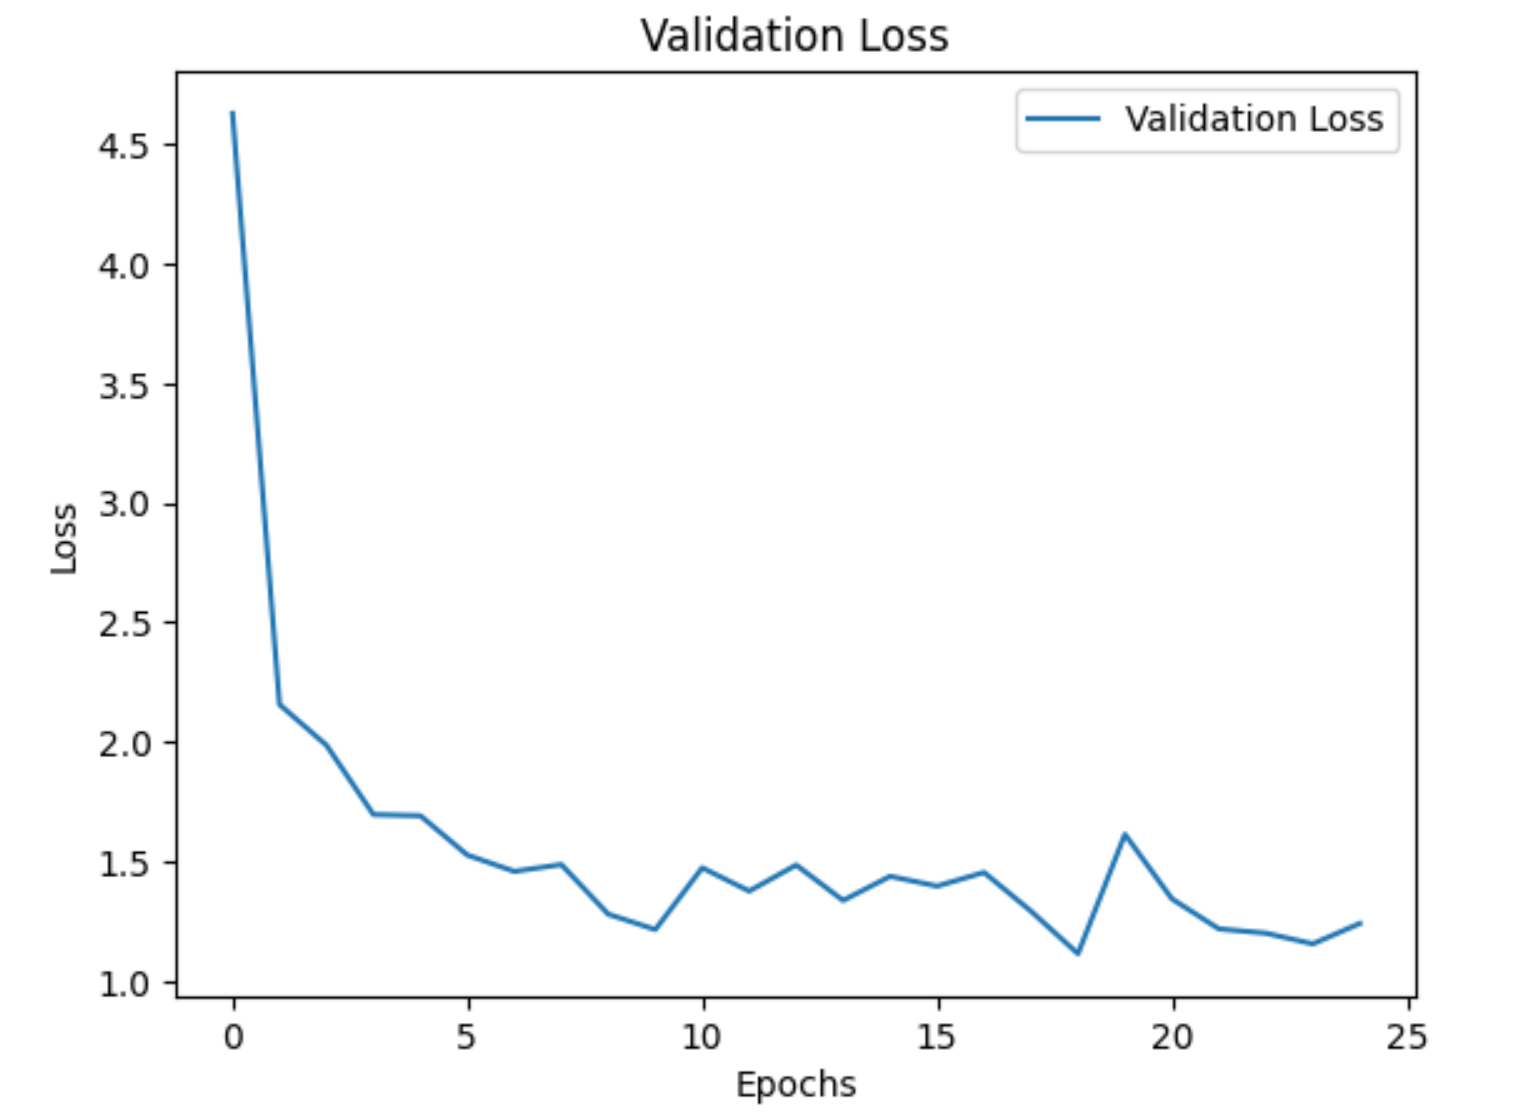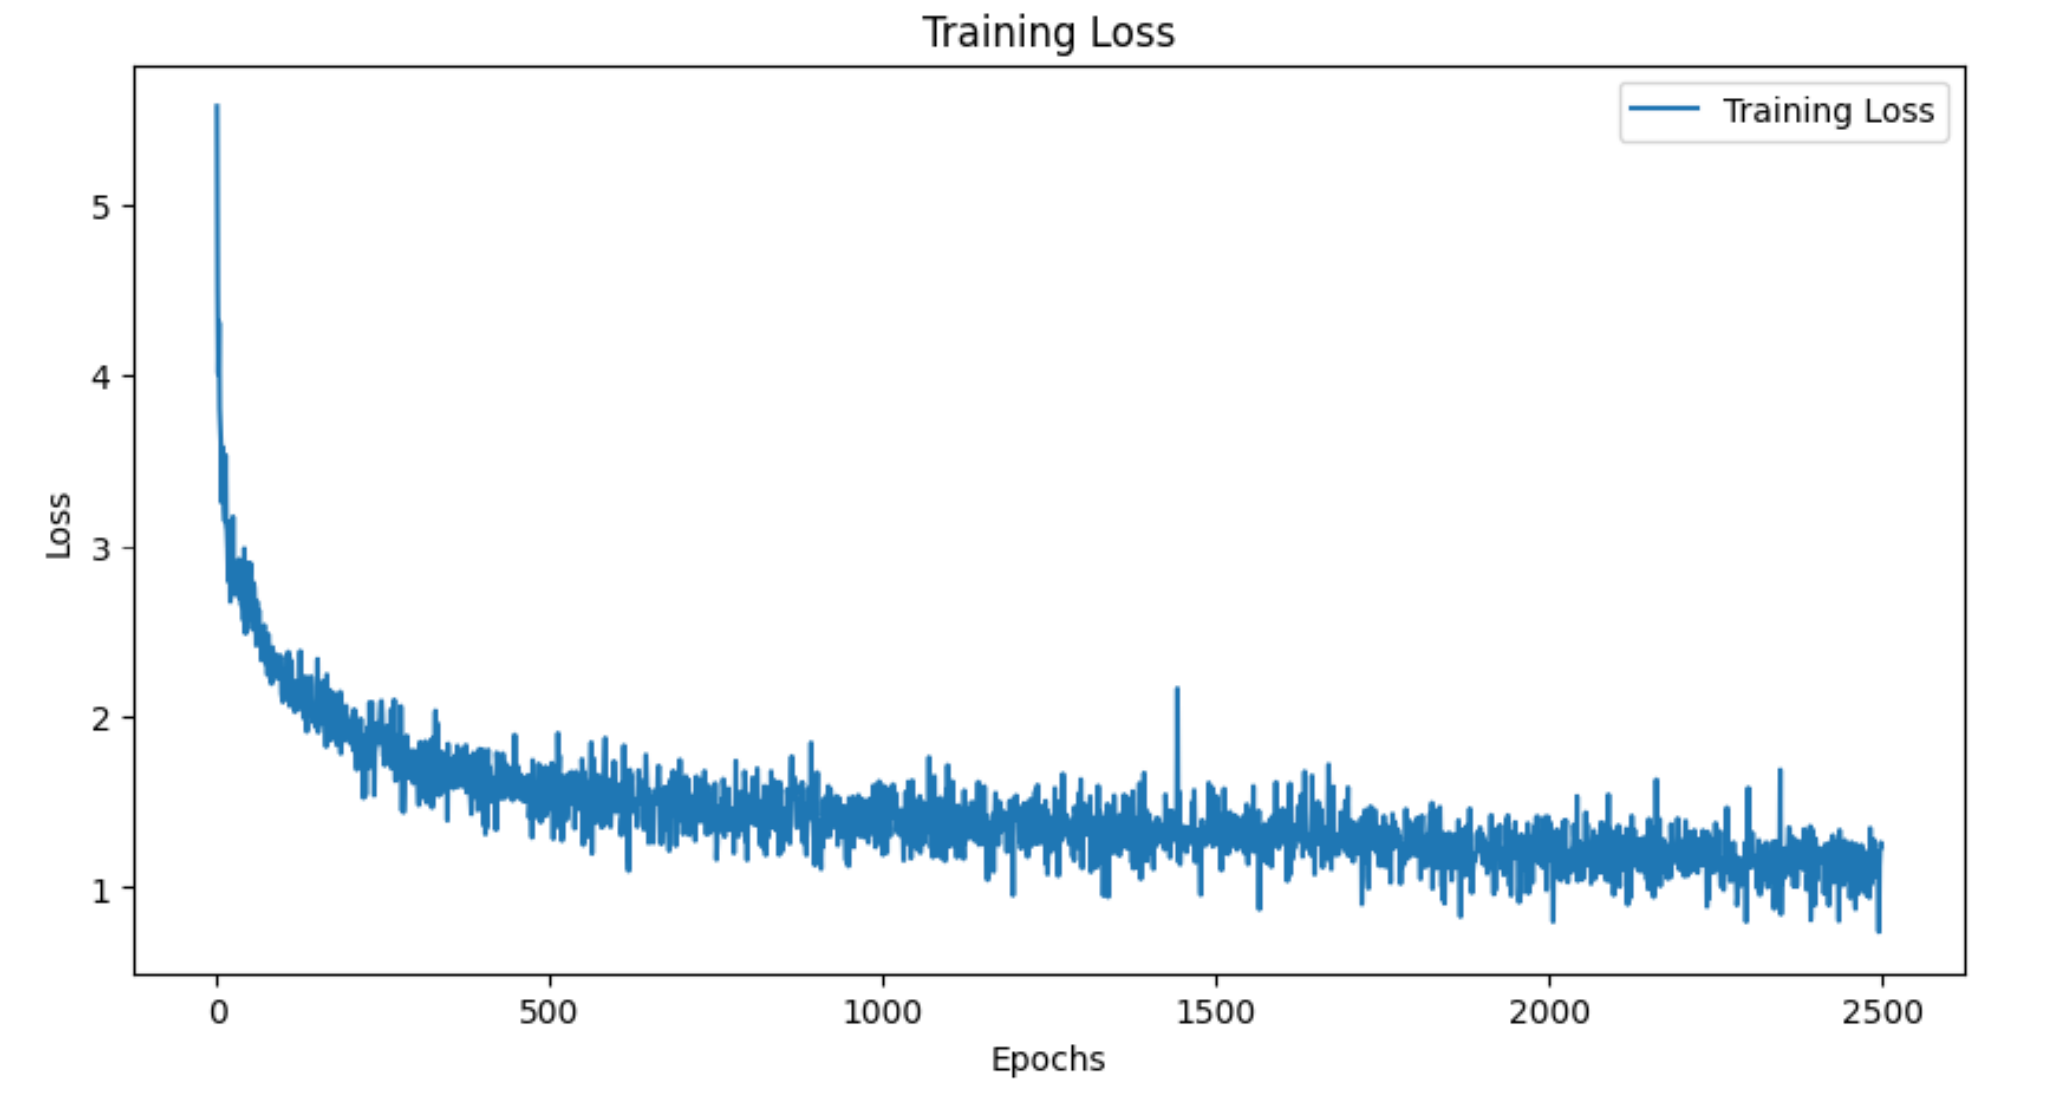

In [ ]:
def get_saliency_map(model, input_sequence):
    model.eval()

    # Ensure input is batched and on GPU
    if len(input_sequence.shape) == 1:
        input_sequence = input_sequence.unsqueeze(0)
    input_sequence = input_sequence.cuda()

    # Convert input tokens to float tensors to allow gradients
    input_float = input_sequence.clone().float().requires_grad_(True)

    # Forward pass using the model's components directly
    embedding_layer = model.net[0]
    embeddings = embedding_layer(input_sequence)

    # Create gradient tensor for embeddings
    embeddings_grad = torch.zeros_like(embeddings, requires_grad=True)
    embeddings_grad.data = embeddings.data

    # Forward pass through rest of model with gradient embeddings
    x = embeddings_grad
    for layer in model.net[1:]:
        x = layer(x)

    # Calculate loss (using prediction of next token)
    loss = x[:, :-1].mean()
    loss.backward()

    # Get importance scores
    saliency = embeddings_grad.grad.abs().sum(dim=-1)

    return saliency.detach().cpu().numpy()


# Create visualizations
plt.figure(figsize=(20, 15))
max_tokens = 30  # Limit number of tokens to display

for i in range(5):
    # Get input sequence
    input_sequence = next(val_loader)

    try:
        # Calculate saliency scores
        saliency = get_saliency_map(model, input_sequence)

        # Get tokens for first sequence up to max_tokens
        tokens = [decode_tokens(input_sequence[0, i:i+1]) for i in range(min(max_tokens, input_sequence.size(1)))]
        scores = saliency[0, :max_tokens]

        # Create subplot
        plt.subplot(5, 1, i+1)

        # Plot bar chart of saliency scores
        plt.bar(range(len(tokens)), scores)

        # Set token labels
        plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
        plt.xlabel('Tokens')
        # Add labels and title
        plt.ylabel('Saliency Score')
        plt.title(f'Sample {i+1} Token Saliency')

        # Adjust layout for readability
        plt.grid(True, alpha=0.3)

    except Exception as e:
        print(f"Error processing sequence {i}: {str(e)}")
        continue

plt.tight_layout()
plt.show()

sample_sequence = next(val_loader)
saliency = get_saliency_map(model, sample_sequence)

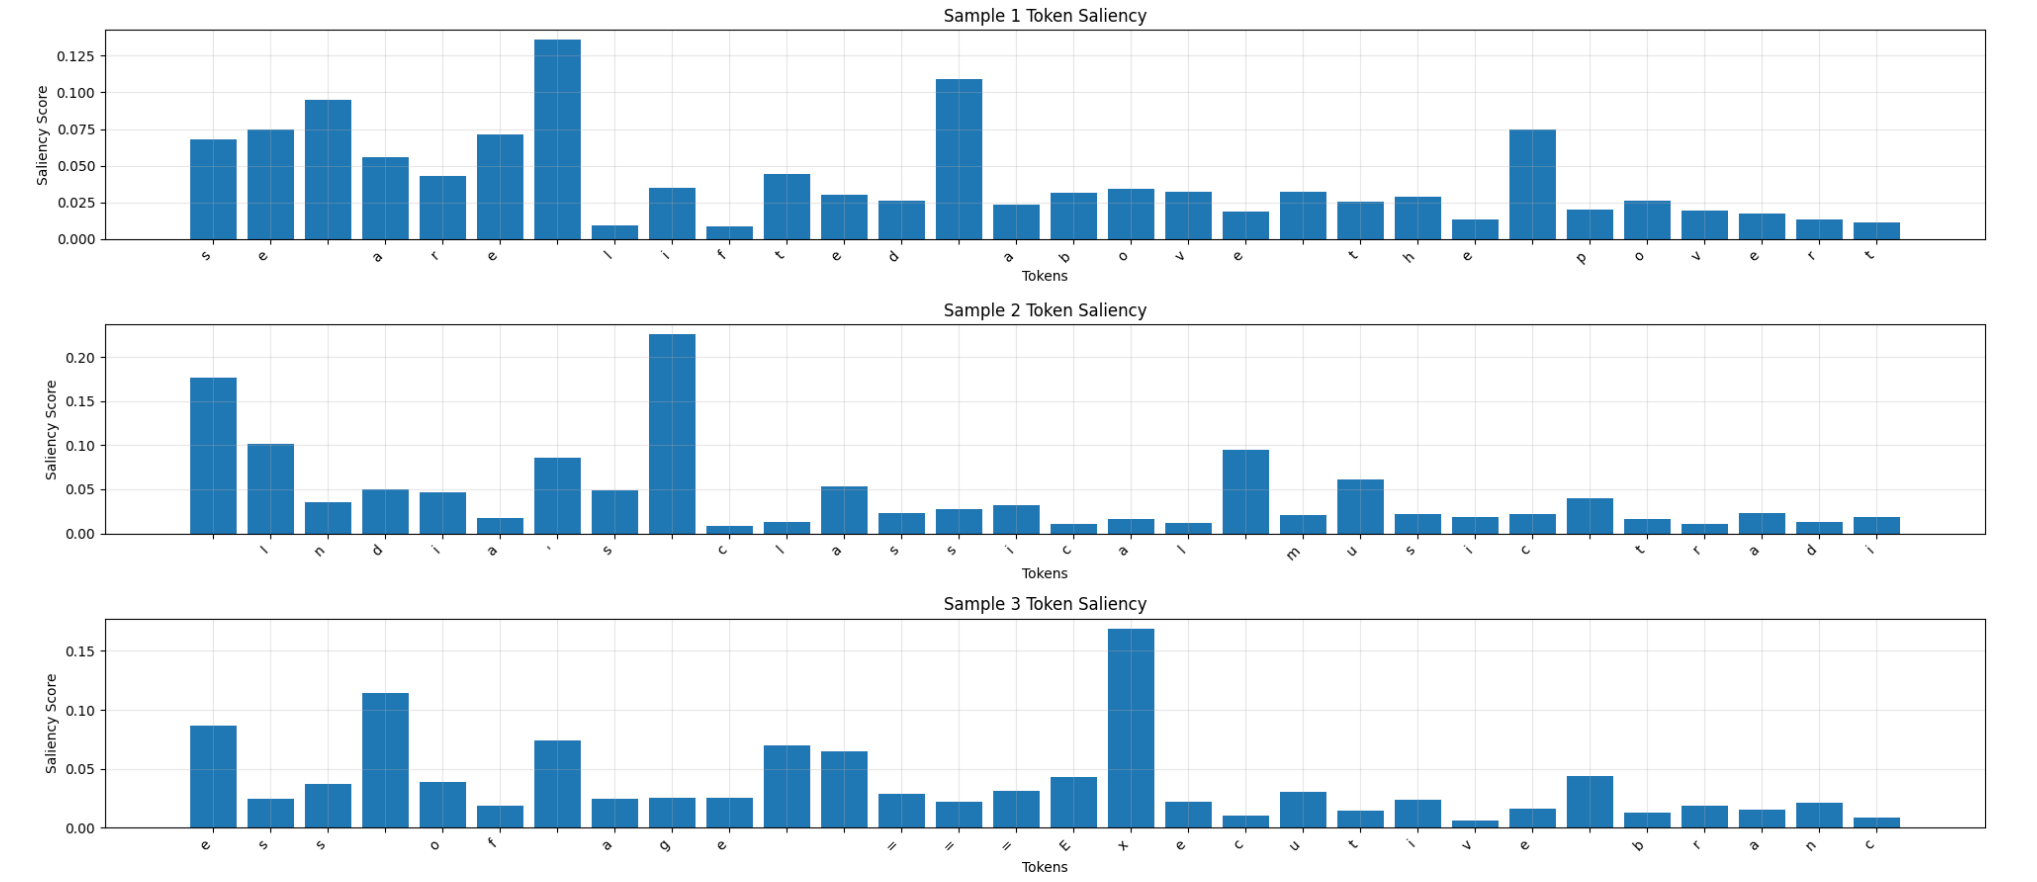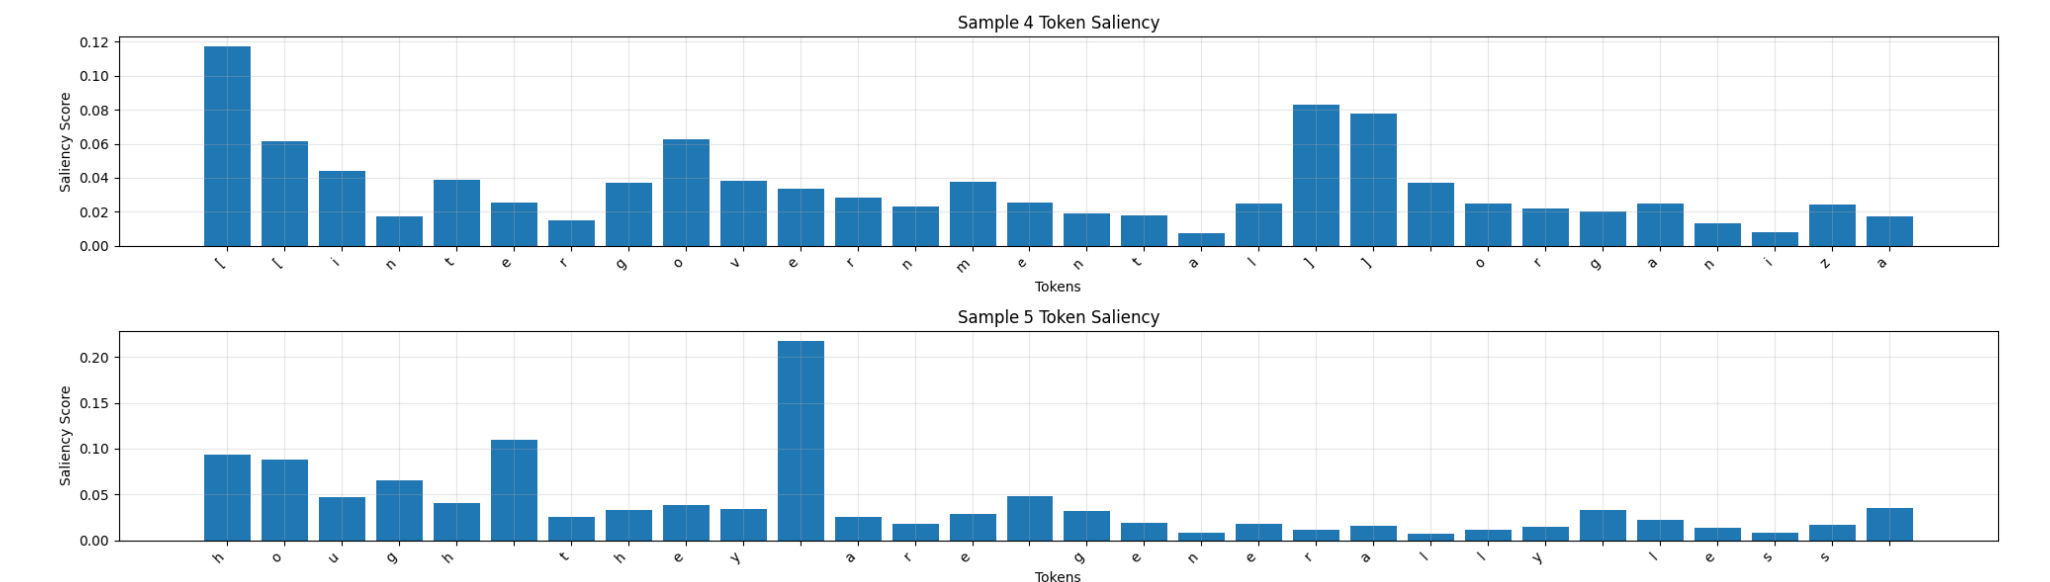